In [1]:
from __future__ import division
%matplotlib nbagg
import pandas as pd
import os, sys
import numpy as np
from collections import defaultdict
from caseDetection import detect_case
from world_map_maker import create_world_map
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#import matplotlib as mpl
#mpl.use("GTK3cairo")
#import matplotlib.pyplot as plt
#plt.plot([1,2,3,4],'*-')

In [2]:
SAMPLENAME = 'Snapshot3'
RESULTS = "results/" + SAMPLENAME + "/"
if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

In [3]:
df_all = pd.read_pickle("data_Apr20/case_detected_all_Apr20.pkl").reset_index()
df_sIP_subcat = pd.read_csv("data/Servers_IMC.txt")

In [248]:
print len( df_sIP_subcat['sIP'].unique() )
print len( df_DNS_filtered['sIP'].unique() )

580
476


In [4]:
subcat_duplicated = defaultdict(list)
for ix, row in df_sIP_subcat.iterrows():
    for subcat in row[2].split("|"):
        subcat_duplicated['sIP'].append(row[0])
        subcat_duplicated['domain'].append(row[1])
        subcat_duplicated['subcat'].append(subcat)
df_sIP_subcat_disjoint = pd.DataFrame(subcat_duplicated)
df_sIP_subcat_disjoint.to_csv("data/Servers_IMC_disjoint.txt")

# Sanitize and Unbiasing
- see how many are case 0 and 4
- select best case for those with multiple case entries per sIP

In [6]:
# lengths of case good and case bad
df_good = df_all [  df_all['case'].isin([1,2,3]) ]
df_bad = df_all [  df_all['case'].isin([-1,0,4]) ]
print len(df_bad) / len(df_good)
print len(df_all)

0.108782614375
135817


In [7]:
# threshold number of sIPs unique tested per country
THRESHOLD = 400

# per country, how many unique sIPs
df_unique_sIP_per_country = df_all.groupby(['country'])['sIP'].unique().apply(lambda x:len(x))
df_current = df_unique_sIP_per_country[df_unique_sIP_per_country > THRESHOLD]
valid_countries = df_current.index
TOTAL_NUM_VALID_COUNTRIES = len(valid_countries)

print valid_countries, TOTAL_NUM_VALID_COUNTRIES

# filter df_good to only valid countries
# remove extra columns
df_valid = df_good[  df_good['country'].isin(valid_countries)   ] [['sIP', 'gIP', 'country',
                                                                    'domain', 'subcat', 'case']]

Index([u'AE', u'AF', u'AL', u'AM', u'AO', u'AR', u'AT', u'AU', u'AZ', u'BA', u'BD', u'BE', u'BF', u'BG', u'BH', u'BI', u'BJ', u'BO', u'BW', u'BY', u'CA', u'CD', u'CG', u'CH', u'CI', u'CL', u'CM', u'CN', u'CO', u'CR', u'CU', u'CZ', u'DE', u'DK', u'DO', u'DZ', u'EC', u'EE', u'EG', u'ES', u'FI', u'FR', u'GA', u'GB', u'GE', u'GH', u'GM', u'GQ', u'GR', u'GT', u'HK', u'HN', u'HR', u'HT', u'HU', u'ID', u'IE', u'IL', u'IN', u'IQ', u'IR', u'IT', u'JM', u'JO', u'JP', u'KE', u'KG', u'KH', u'KR', u'KZ', u'LA', u'LK', u'LR', u'LS', u'LT', u'LV', u'LY', u'MA', u'MD', u'MG', u'MK', u'ML', u'MM', u'MR', u'MU', u'MW', u'MX', u'MY', u'MZ', u'NA', u'NE', u'NG', u'NI', u'NL', u'NO', u'NP', u'NZ', u'OM', u'PA', u'PE', ...], dtype='object') 142


In [8]:
gp_good_sIP_country = df_valid.groupby(['sIP', 'country'])

# even though there are multiple cases per sIP, country pair
# select only one
df_per_sIP_country = gp_good_sIP_country['case'].unique().reset_index()
df_per_sIP_country['count'] = gp_good_sIP_country['case'].count().reset_index()['case']
df_per_sIP_country['unique_count'] = df_per_sIP_country['case'].apply(lambda x: len(x))

In [9]:
df_temp = df_per_sIP_country[df_per_sIP_country['unique_count'] > 1]
df_temp['case'].head()

55     [3, 2]
73     [2, 3]
78     [3, 2]
136    [2, 1]
137    [2, 1]
Name: case, dtype: object

In [10]:
print "sIP, country with discrepancy: ", len( df_per_sIP_country[df_per_sIP_country['unique_count'] > 1] ) / len (df_per_sIP_country)

sIP, country with discrepancy:  0.0506393861893


#### choose first valid index of each sip,country pair

In [11]:
def choose_valid_case(case_list):
    """ return first case that was either 1, 2, 3"""
    for x in case_list:
        if (x == 1) or (x == 2) or (x == 3):
            return x
    return case_list[0]

In [12]:
df_unique = gp_good_sIP_country['case'].apply(choose_valid_case).reset_index()
# drop duplicate rows with same sIP, country, case
df_unique = df_unique.drop_duplicates()
print len( df_unique.sIP.unique() )
print len( df_unique.country.unique() )
print len( df_unique )

506
142
64515


In [13]:
# Quick check
df_temp = df_unique.groupby(['sIP', 'country'])['case'].unique().reset_index()
df_temp['count'] = df_unique.groupby(['sIP', 'country'])['case'].count().reset_index()['case']
df_temp['unique_count'] = df_per_sIP_country['case'].apply(lambda x: len(x))
df_temp[df_temp['count']>1]

Empty DataFrame
Columns: [sIP, country, case, count, unique_count]
Index: []

## Merge unique selected entries with subcats

In [23]:
df_unbiased = df_unique.merge(df_sIP_subcat_disjoint, on=['sIP'])
df_unbiased.subcat.unique()

array(['circum', 'world', 'recreation', 'vpn', 'society', 'health',
       'kids_and_teens', 'games', 'adult', 'sports', 'computers',
       'science', 'arts', 'regional', 'shopping', 'news', 'reference',
       'business', 'home'], dtype=object)

In [24]:
# Quick check
df_unbiased[df_unbiased['domain']=='history.com'].head()

sIP country  case       domain          subcat
29513  184.73.236.82      AE     2  history.com  kids_and_teens
29514  184.73.236.82      AE     2  history.com            arts
29515  184.73.236.82      AE     2  history.com        business
29516  184.73.236.82      AL     2  history.com  kids_and_teens
29517  184.73.236.82      AL     2  history.com            arts

## Data description
- total experiments: means, var per country
- total experiments: means, var per subcat

In [36]:
# save list of countries
pd.Series(df_unbiased.reset_index()['country'].unique()).to_csv(RESULTS+"list_of_countries.csv")

In [37]:
df_experiment_stats = df_unbiased.groupby(['country', 'subcat']).count()['sIP'].unstack()

In [38]:
per_country = df_experiment_stats.describe().T[['count','mean','std','min','max']].rename(
    columns={'count':'num_countries', 'mean':'avg_num_measurements_per_subcat'})
per_country.to_html(RESULTS + "experiment_total_stats_per_country.html")
per_subcat = df_experiment_stats.T.describe().T[['count','mean','std','min','max']].rename(
    columns={'count':'num_subcats', 'mean':'avg_num_measurements_per_country'})
per_subcat.to_html(RESULTS + "experiment_total_stats_per_subcat.html")

### Save domain/country/case

In [135]:
df_unbiased.to_pickle(RESULTS + 'domain_censorship_results_repeated-categ.pkl')
df_unbiased.to_csv(RESULTS + 'domain_censorship_results_repeated-categ.csv')
df_unbiased.head(10)

sIP country  case      domain  subcat
0  1.209.122.23      AE     2  riseup.net  circum
1  1.209.122.23      AF     2  riseup.net  circum
2  1.209.122.23      AL     2  riseup.net  circum
3  1.209.122.23      AM     2  riseup.net  circum
4  1.209.122.23      AO     2  riseup.net  circum
5  1.209.122.23      AR     2  riseup.net  circum
6  1.209.122.23      AT     2  riseup.net  circum
7  1.209.122.23      AU     2  riseup.net  circum
8  1.209.122.23      BA     2  riseup.net  circum
9  1.209.122.23      BD     2  riseup.net  circum

<hr/>
# BELOW THIS IS ANALYSIS
<hr/>

## CENSORSHIP RATIOS
- count country, case, subcat

In [54]:
df_country_case_subcat = df_unbiased.groupby(['country', 'case', 'subcat'])['sIP'].count().unstack(1).fillna(0)
df_country_case_subcat.head(10)

case                    1   2  3
country subcat                  
AE      adult           3  24  3
        arts            3  35  2
        business        4  25  6
        circum          1  13  1
        computers       2  26  8
        games           0  18  6
        health          1  24  4
        home            3  23  4
        kids_and_teens  3  25  2
        news            2  22  2

## ADD relevant ratio columns

In [78]:
df_country_case_subcat = df_unbiased.groupby(['country', 'case', 'subcat'])['sIP'].count().unstack(1).fillna(0)
df_country_case_subcat = df_country_case_subcat.rename(columns={1:'1', 2:'2', 3:'3'})
df_country_case_subcat['total'] = df_country_case_subcat[['1','2','3']].sum(axis=1)
df_country_case_subcat['case1'] = df_country_case_subcat['1']/df_country_case_subcat['total']
df_country_case_subcat['case2'] = df_country_case_subcat['2']/df_country_case_subcat['total']
df_country_case_subcat['case3'] = df_country_case_subcat['3']/df_country_case_subcat['total']
df_country_case_subcat['case13'] = (df_country_case_subcat['1'] + df_country_case_subcat['3'])/df_country_case_subcat['total']
df_country_case_subcat['case1/case13'] = df_country_case_subcat['1']/(df_country_case_subcat['1'] + df_country_case_subcat['3'])
df_country_case_subcat.head()

case               1   2  3  total     case1     case2     case3    case13  \
country subcat                                                               
AE      adult      3  24  3     30  0.100000  0.800000  0.100000  0.200000   
        arts       3  35  2     40  0.075000  0.875000  0.050000  0.125000   
        business   4  25  6     35  0.114286  0.714286  0.171429  0.285714   
        circum     1  13  1     15  0.066667  0.866667  0.066667  0.133333   
        computers  2  26  8     36  0.055556  0.722222  0.222222  0.277778   

case               case1/case13  
country subcat                   
AE      adult               0.5  
        arts                0.6  
        business            0.4  
        circum              0.5  
        computers           0.2

In [64]:
all_results = list(df_country_case_subcat.columns)
print all_results

['1', '2', '3', 'total', 'case1', 'case2', 'case3', 'case13', 'case1/case13']


In [79]:
censorship_ratio = defaultdict(int)
for key in ['case1', 'case3', 'case13', 'case2', 'total']:
    censorship_ratio[key] = df_country_case_subcat[key].unstack(0)
    censorship_ratio[key].to_html(RESULTS + 'ALL_Apr20_censorship_'+key+'_updated.html')

In [82]:
# check
df_country_case_subcat[['case1','case2','case3']].sum(axis=1)

country  subcat        
AE       adult             1
         arts              1
         business          1
         circum            1
         computers         1
         games             1
         health            1
         home              1
         kids_and_teens    1
         news              1
         recreation        1
         reference         1
         regional          1
         science           1
         shopping          1
...
ZW       computers         1
         games             1
         health            1
         home              1
         kids_and_teens    1
         news              1
         recreation        1
         reference         1
         regional          1
         science           1
         shopping          1
         society           1
         sports            1
         vpn               1
         world             1
Length: 2698, dtype: float64

# BY SUBCAT per COUNTRY and vice versa
- draw above plots for each country
- each subplot

In [132]:
df_censorship = df_country_case_subcat.reset_index()
df_per_subcat = df_censorship[ df_censorship['subcat']==subcat ].sort('case2')
df_censorship.to_html(RESULTS + 'all_case_ratios.html')
df_censorship.to_pickle(RESULTS + 'all_case_ratios.pkl')
# check
len(df_per_subcat.set_index('country'))

142

<IPython.core.display.Javascript object>


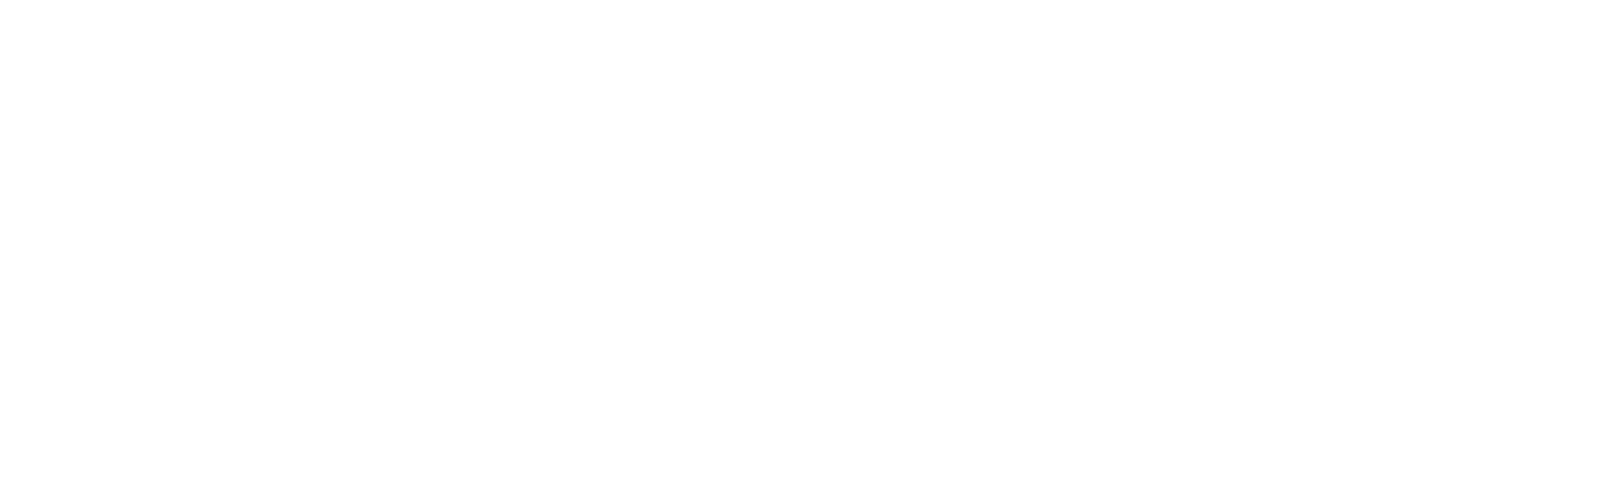

<IPython.core.display.Javascript object>


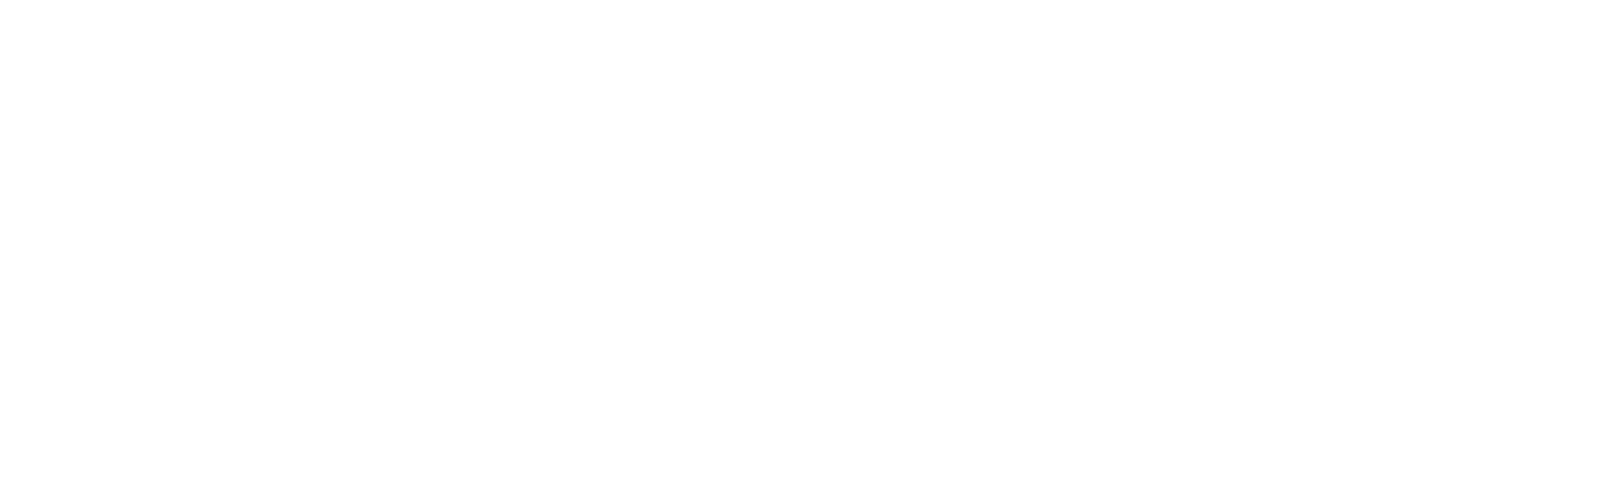

<IPython.core.display.Javascript object>


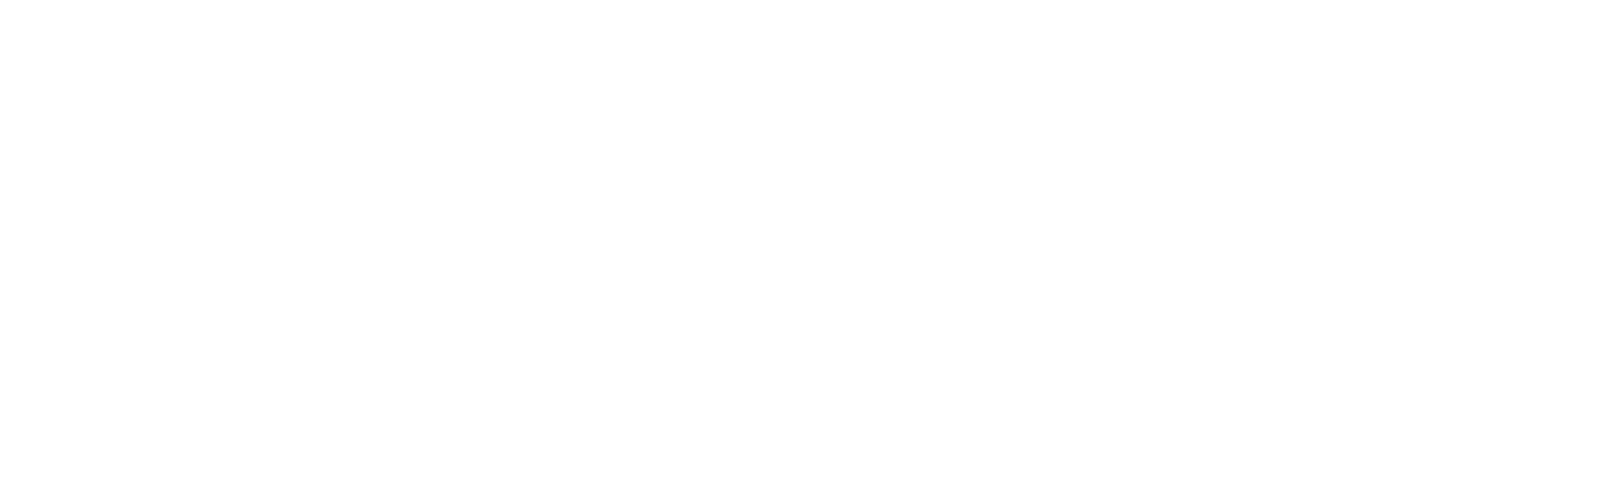

<IPython.core.display.Javascript object>


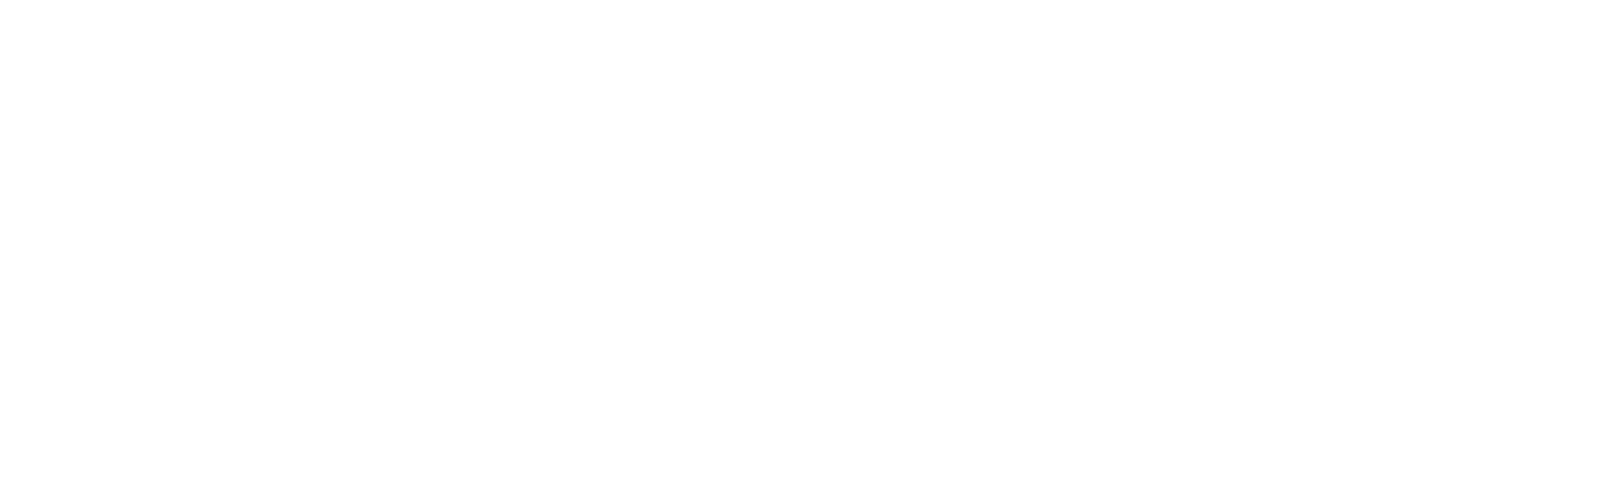

<IPython.core.display.Javascript object>


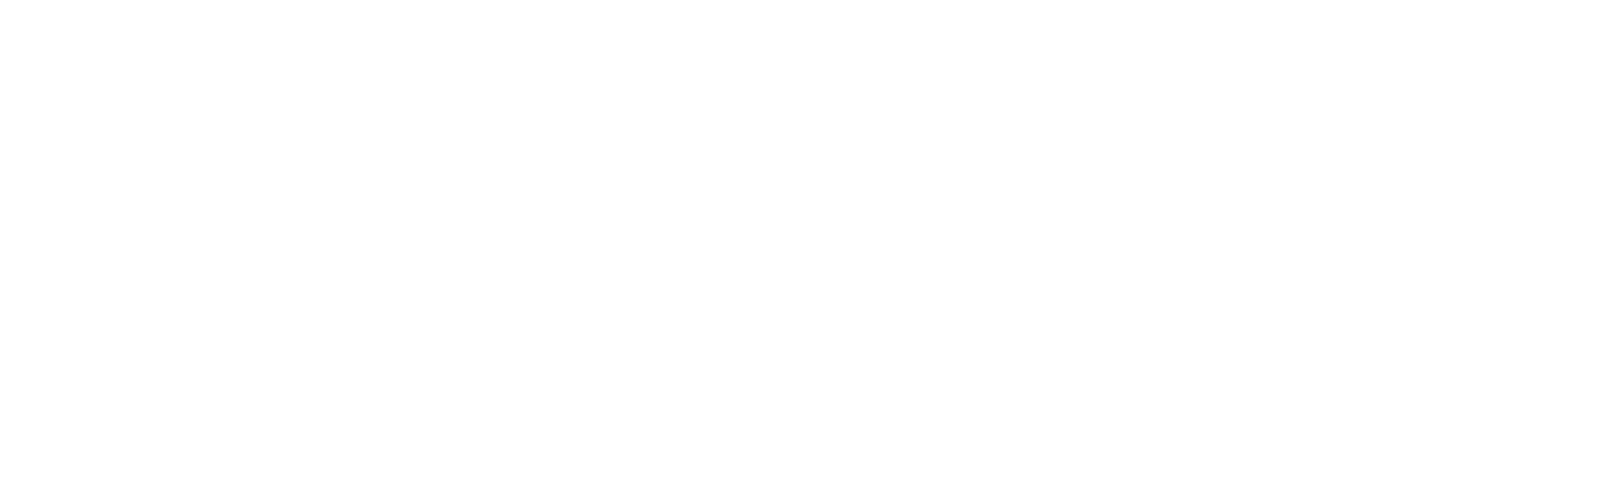

<IPython.core.display.Javascript object>


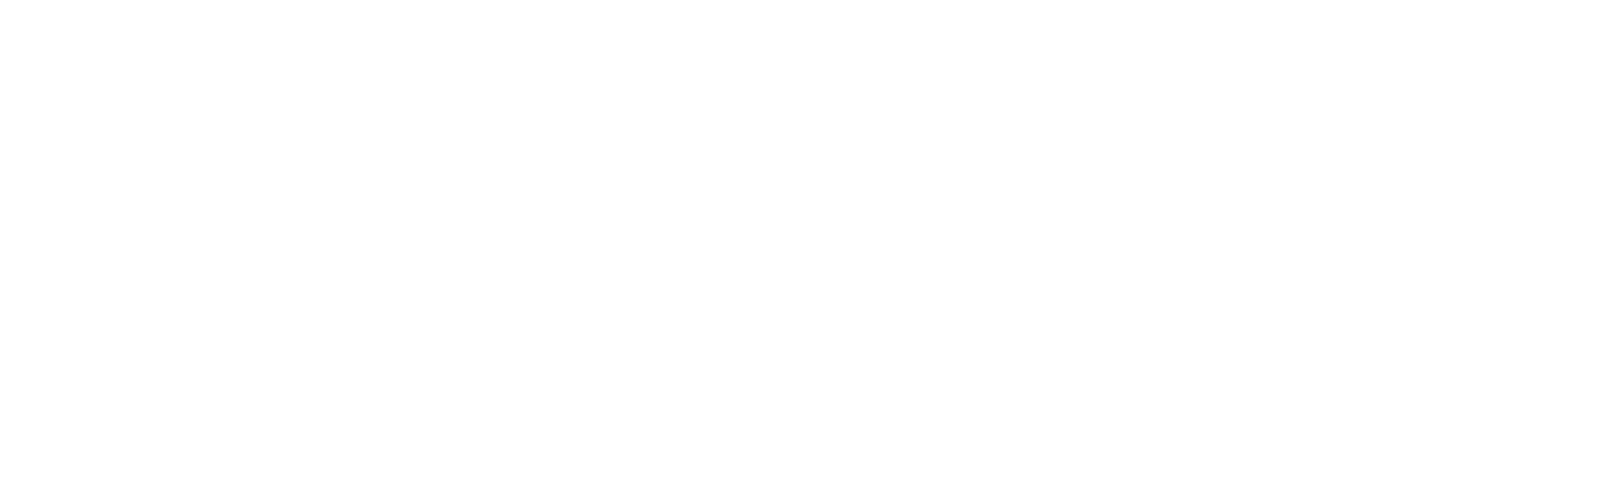

<IPython.core.display.Javascript object>


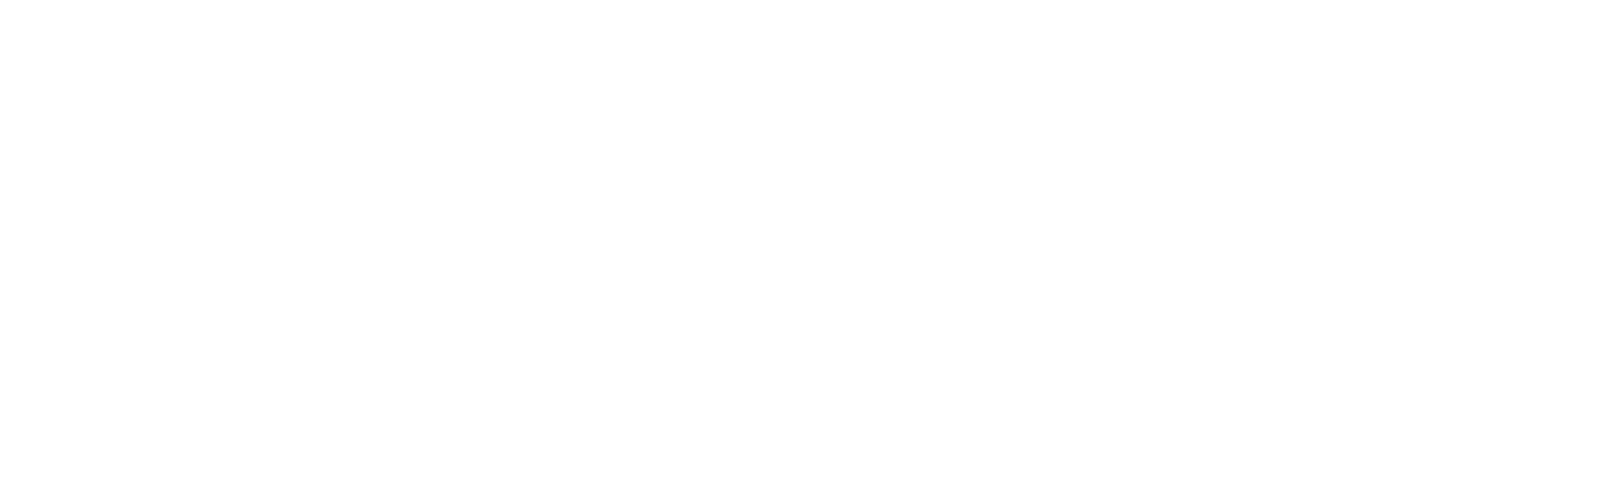

<IPython.core.display.Javascript object>


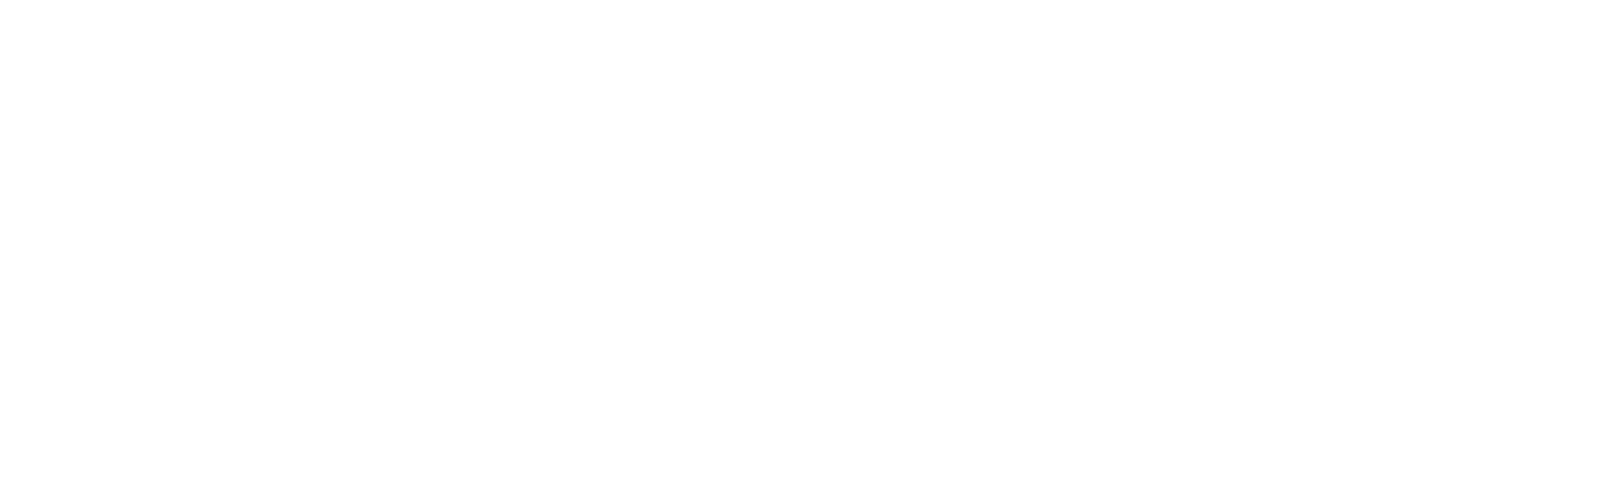

<IPython.core.display.Javascript object>


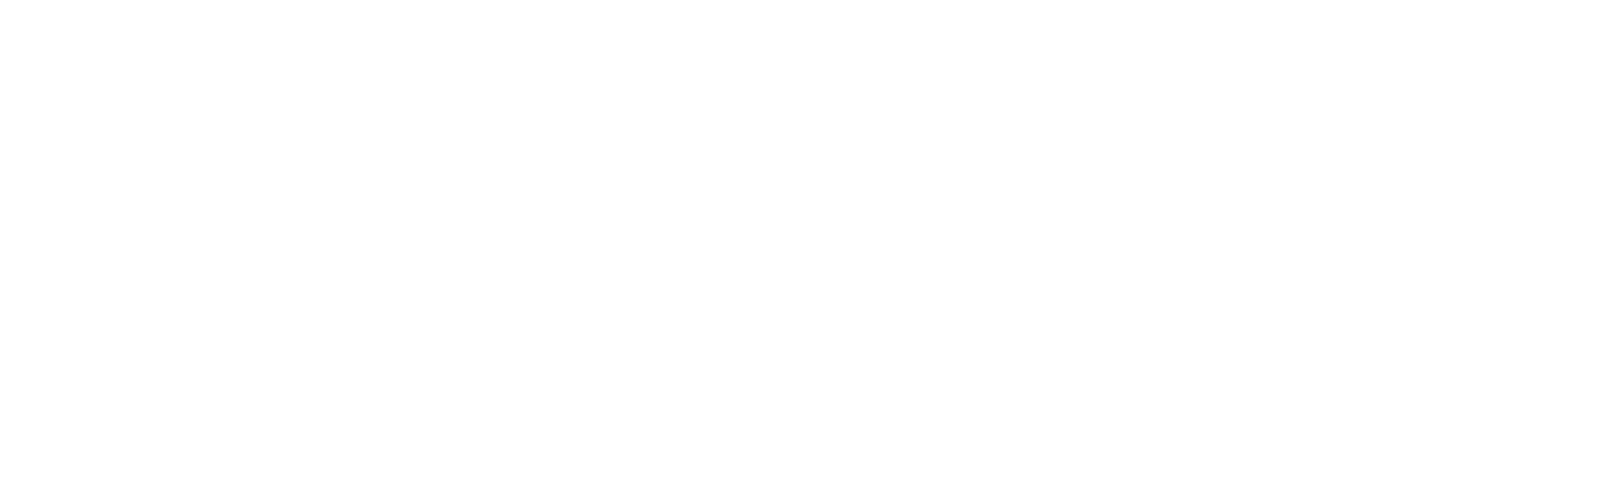

<IPython.core.display.Javascript object>


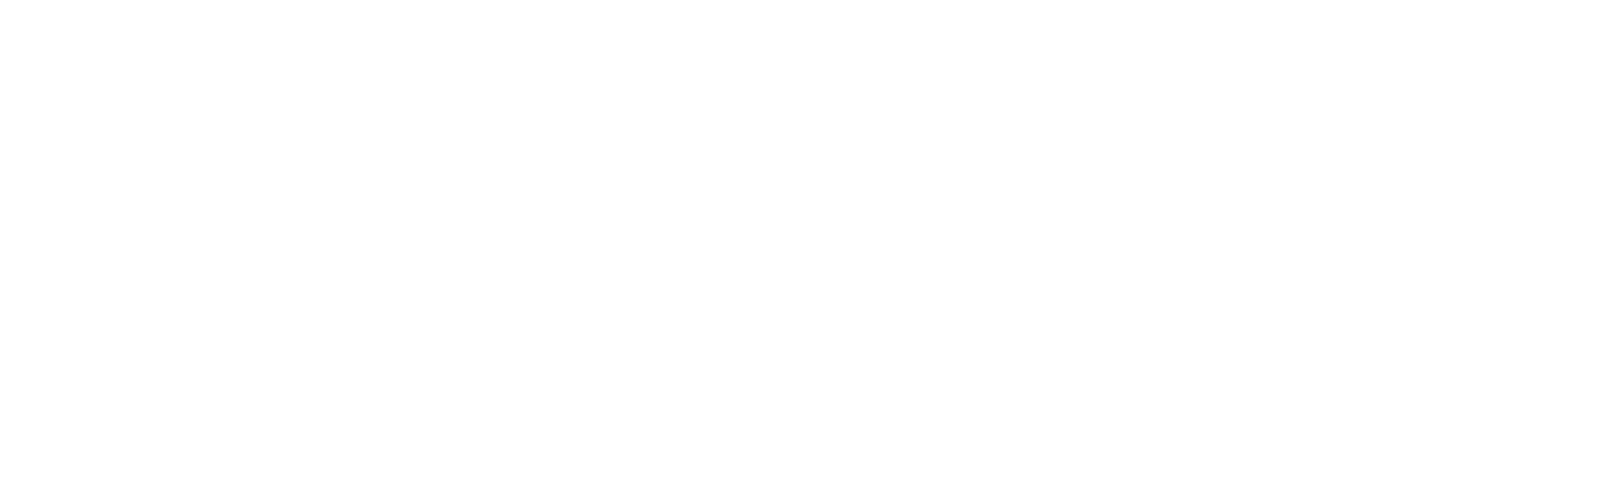

<IPython.core.display.Javascript object>


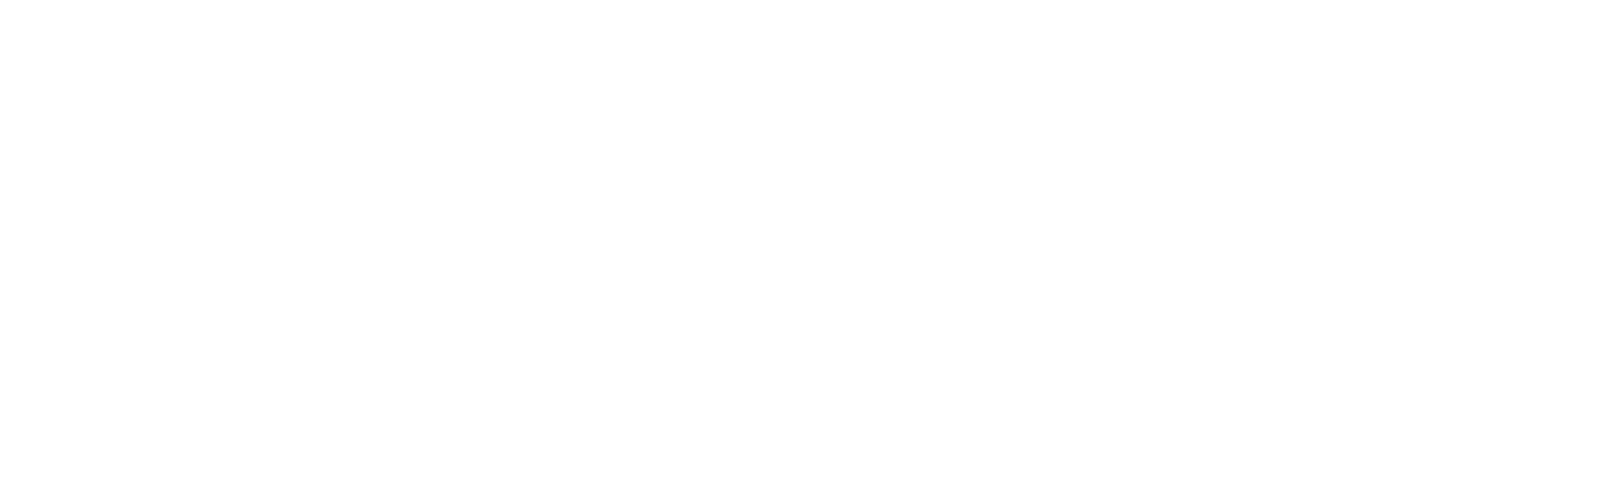

<IPython.core.display.Javascript object>


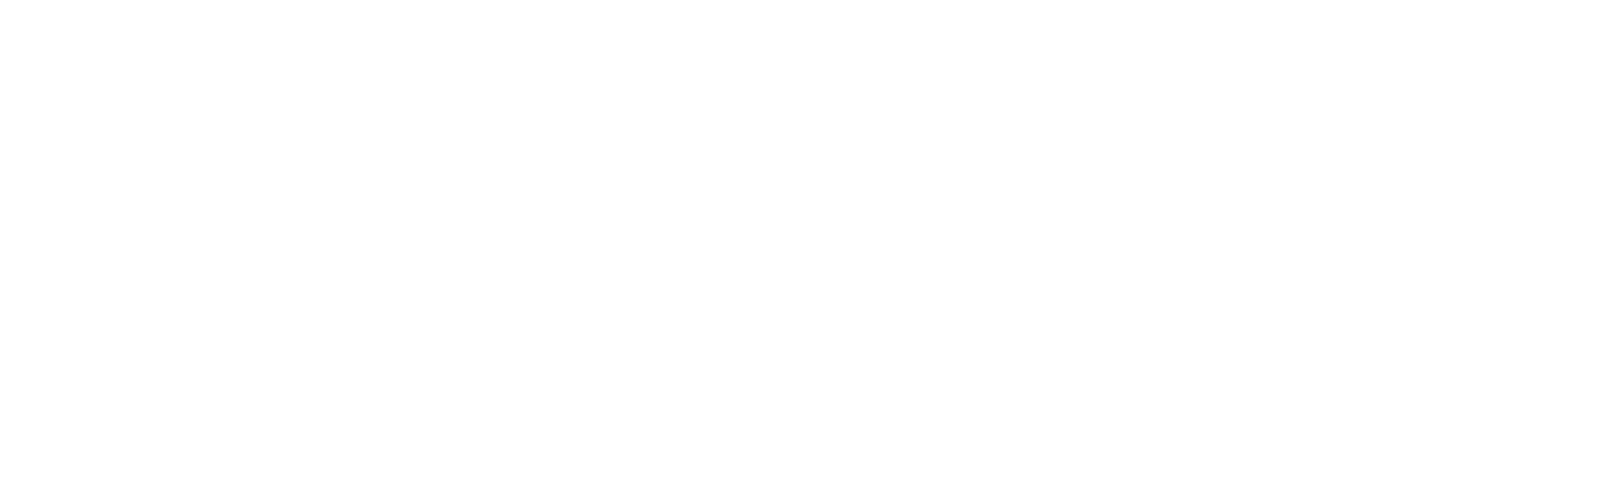

<IPython.core.display.Javascript object>


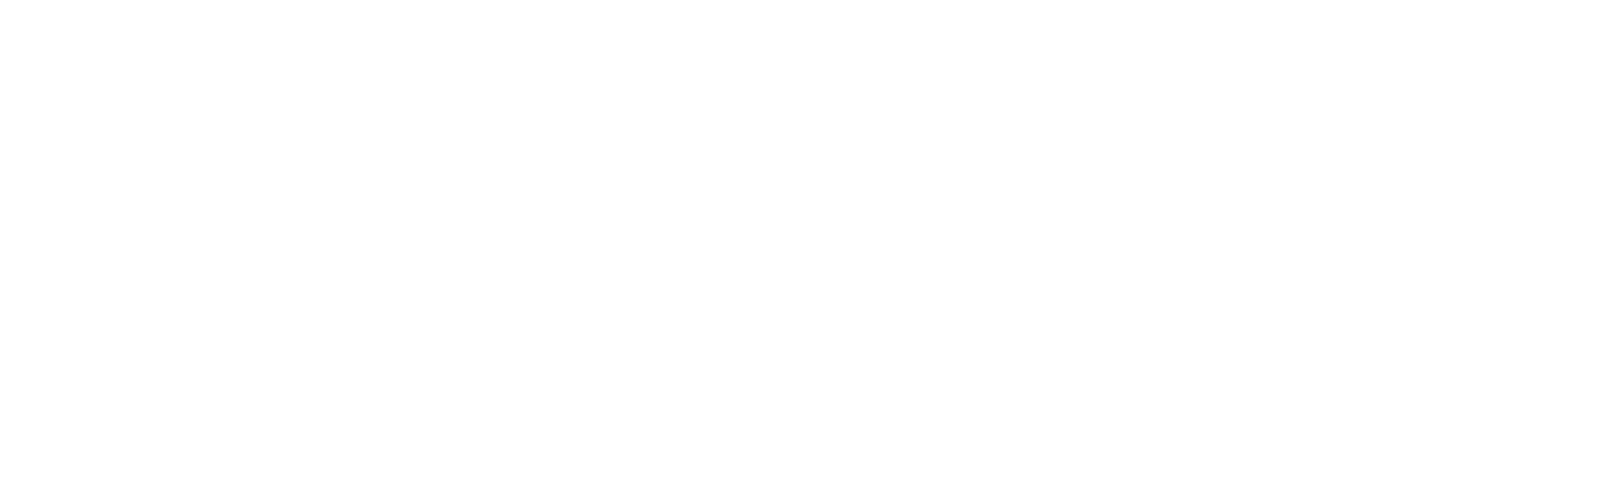

<IPython.core.display.Javascript object>


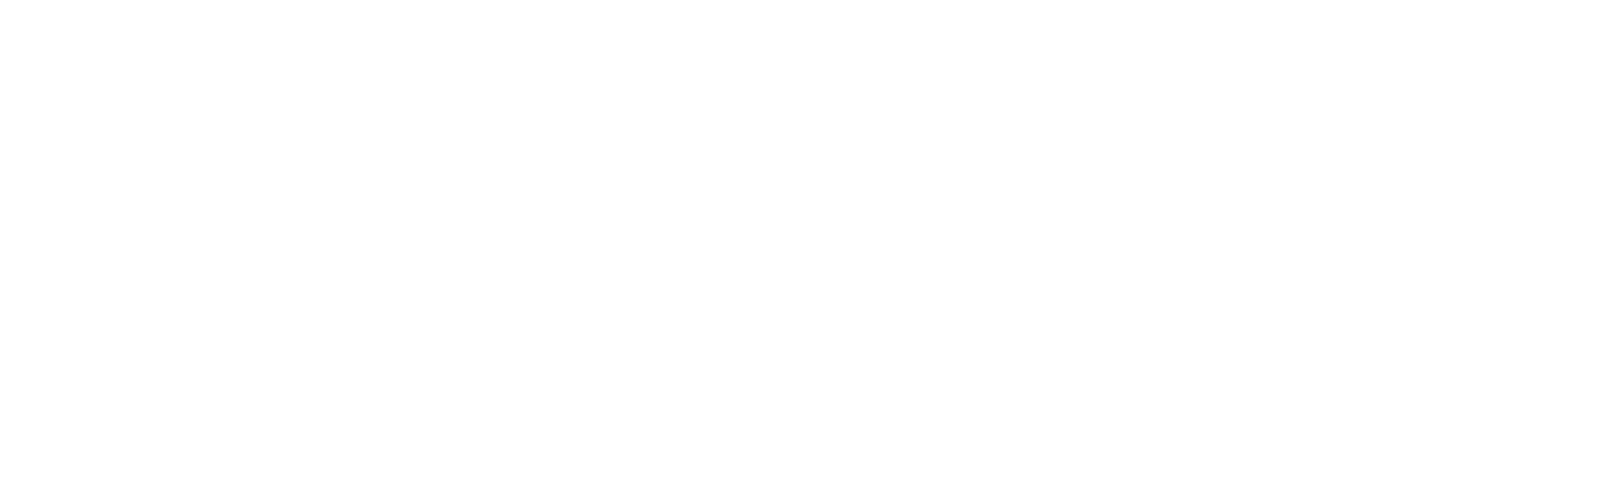

<IPython.core.display.Javascript object>


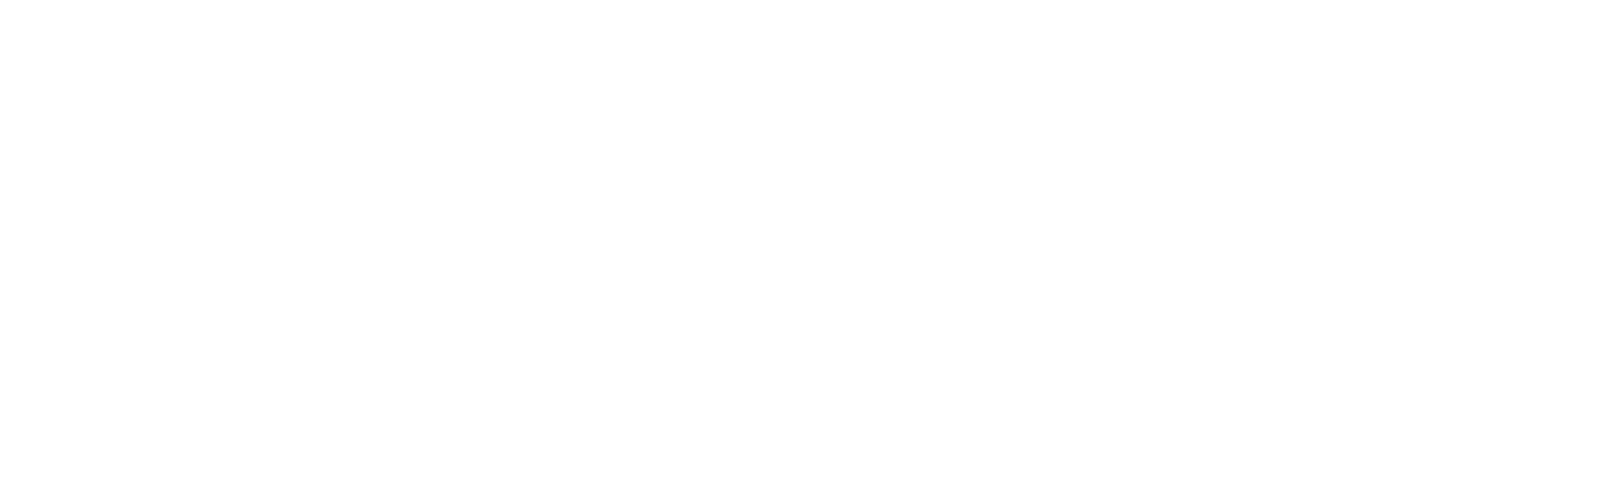

<IPython.core.display.Javascript object>


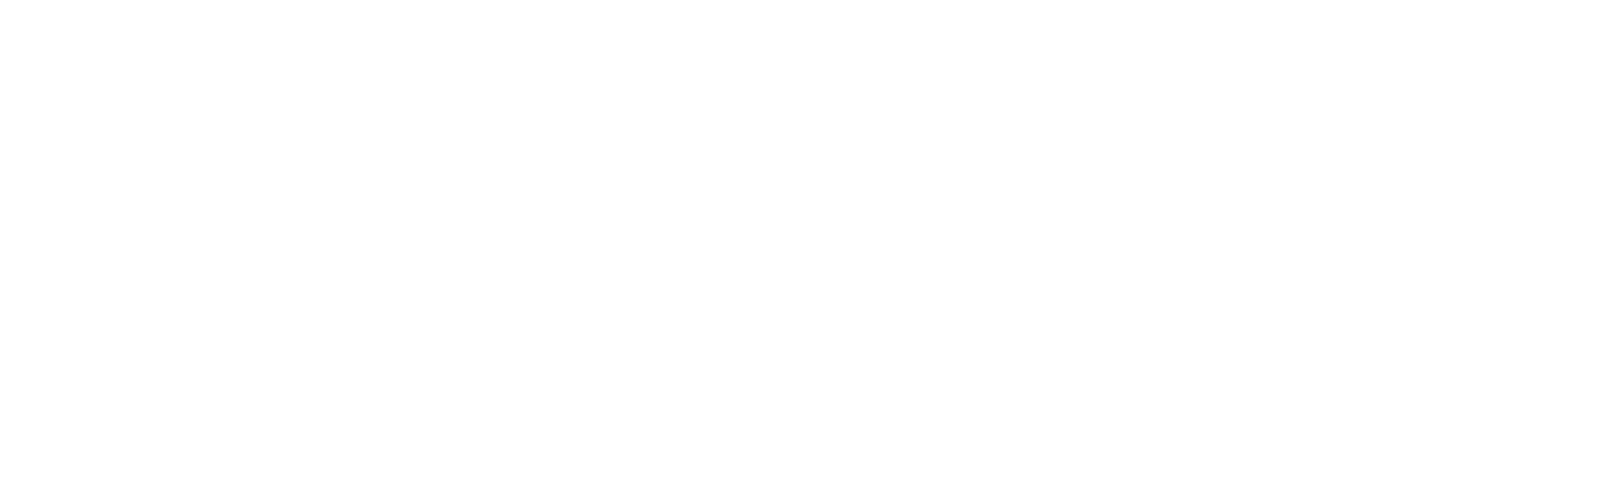

<IPython.core.display.Javascript object>


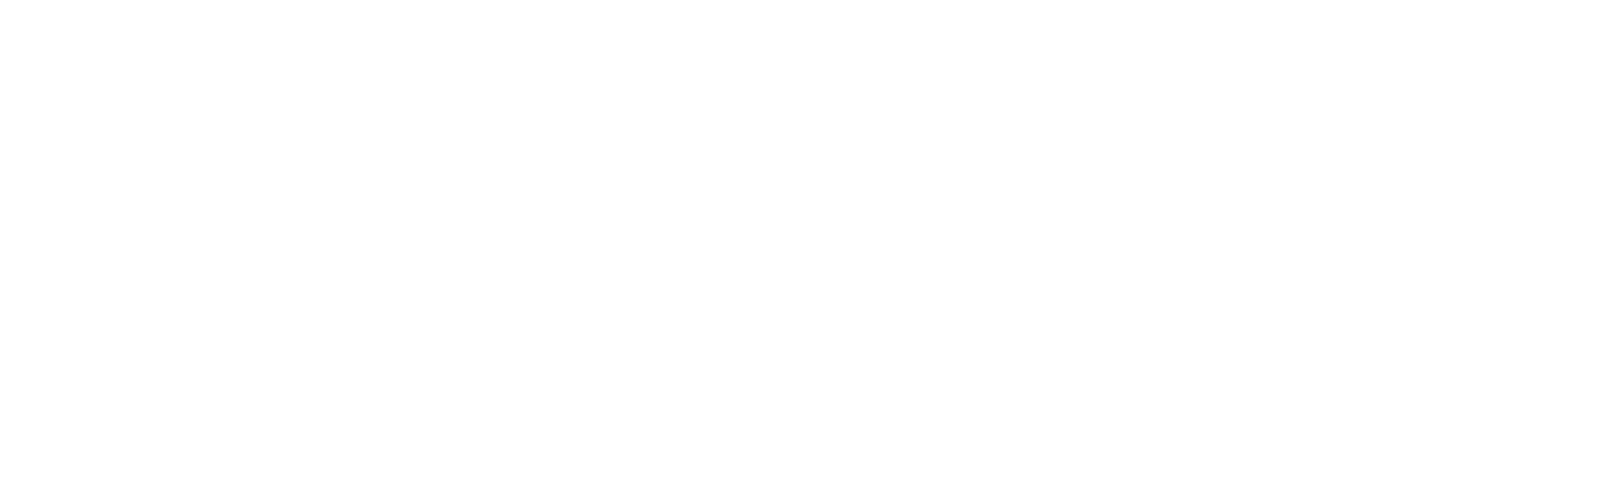

<IPython.core.display.Javascript object>


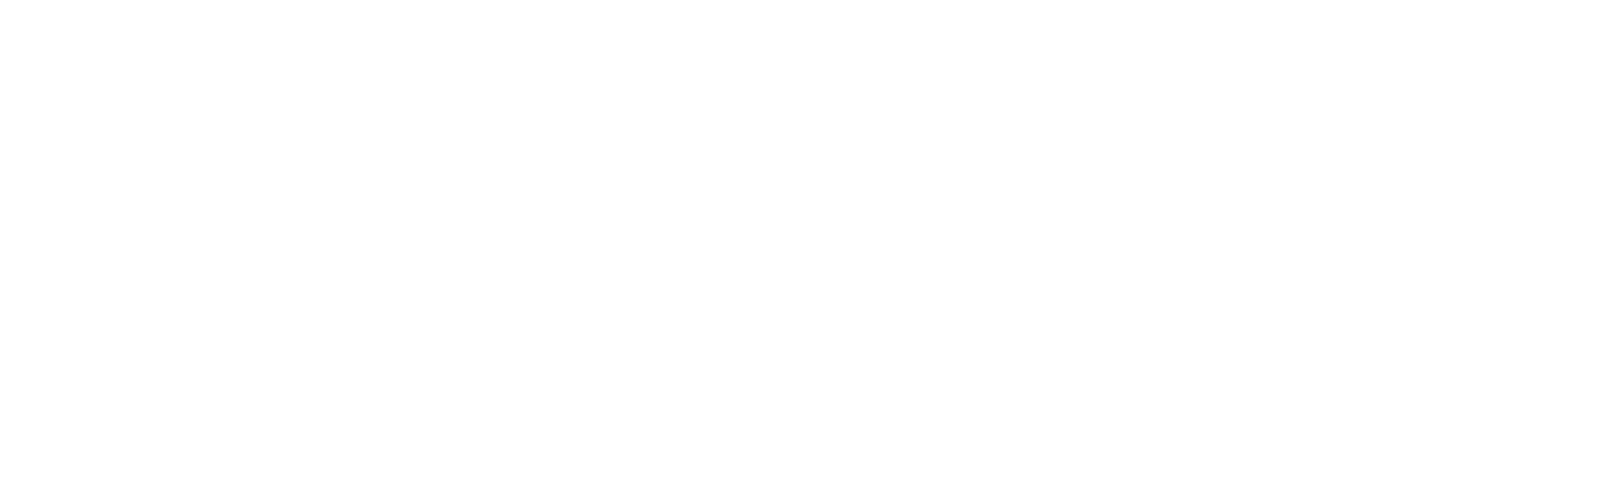

<IPython.core.display.Javascript object>


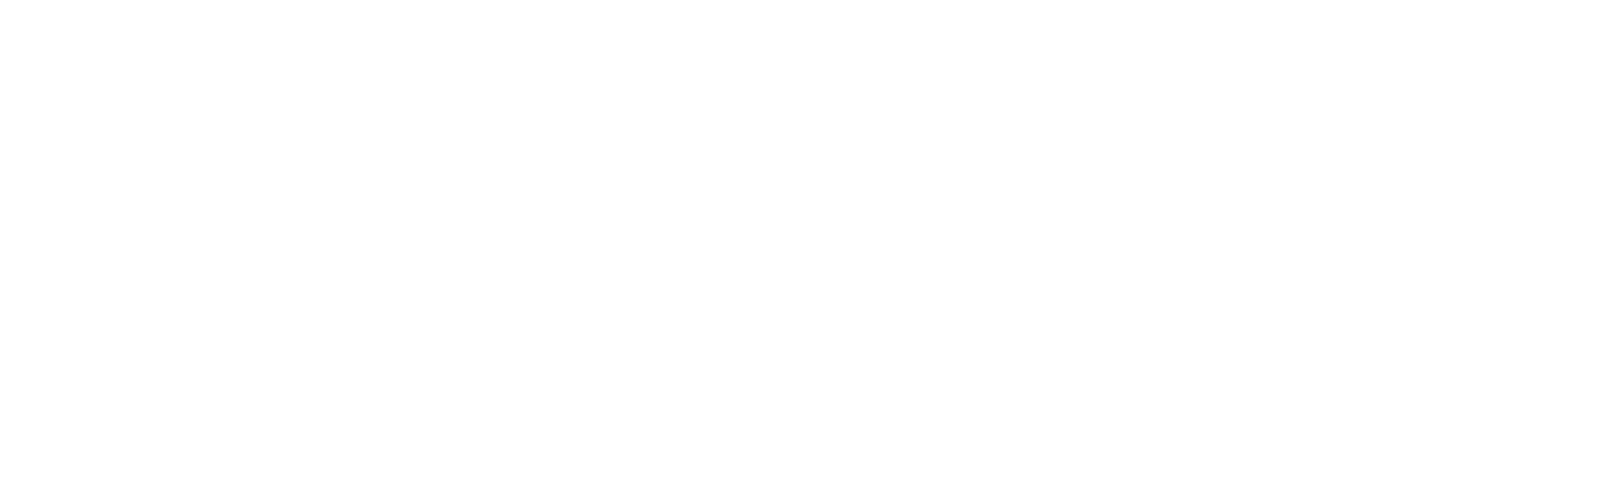

In [94]:
currFolder = RESULTS + "subcat/"
if not os.path.exists(currFolder):
    os.makedirs(currFolder)

for subcat in df_censorship.subcat.unique():
    
    df_per_subcat = df_censorship[ df_censorship['subcat']==subcat ].sort('case2')
    
    #fig1, ax1 = plt.subplits(1, 1, figsize=(10,7))
    fig1, ax1 = plt.subplots(1,1, figsize=(20,6))
    df = df_per_subcat.set_index('country')[['case2', 'case1','case3']].rename({'case2':'no-packets-dropped',
                                                                  'case1':'server-to-client-dropped',
                                                                  'case3':'client-to-server-dropped'})
    df.plot(kind='bar', stacked=True, ax=ax1)
    ax1.legend(loc='best', prop={'size':14})
    fig1.tight_layout()
    fig1.savefig(currFolder + "cases_ratio_by_country_stacked_bar_"+subcat)
    plt.close()

# PCA

In [95]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [96]:
tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2)

In [97]:
df_censorship.subcat.unique()

array(['adult', 'arts', 'business', 'circum', 'computers', 'games',
       'health', 'home', 'kids_and_teens', 'news', 'recreation',
       'reference', 'regional', 'science', 'shopping', 'society', 'sports',
       'vpn', 'world'], dtype=object)

In [99]:
df_censorship.head()

case country     subcat  1   2  3  total     case1     case2     case3  \
0         AE      adult  3  24  3     30  0.100000  0.800000  0.100000   
1         AE       arts  3  35  2     40  0.075000  0.875000  0.050000   
2         AE   business  4  25  6     35  0.114286  0.714286  0.171429   
3         AE     circum  1  13  1     15  0.066667  0.866667  0.066667   
4         AE  computers  2  26  8     36  0.055556  0.722222  0.222222   

case    case13  case1/case13  
0     0.200000           0.5  
1     0.125000           0.6  
2     0.285714           0.4  
3     0.133333           0.5  
4     0.277778           0.2

In [100]:
df_filtered = df_censorship[['subcat','country','case1','case2','case3', 'case13', 'case1/case13']]
#df_filtered['case1/case13'] = df_filtered['case1']/( df_filtered['case1'] + df_filtered['case3'] )
#df_filtered2 = df_filtered[['subcat','country','case1','case2','case3']]
#df_filtered3 = df_filtered[['subcat','country','case1/case13','case2']]

In [105]:
df_multidim = df_filtered.pivot(index='country', columns='subcat')
df_multidim2 = df_filtered[['subcat','country','case1','case2','case3']].pivot(index='country', columns='subcat')
df_multidim3 = df_filtered[['subcat','country','case13','case1/case13']].pivot(index='country', columns='subcat')

<IPython.core.display.Javascript object>


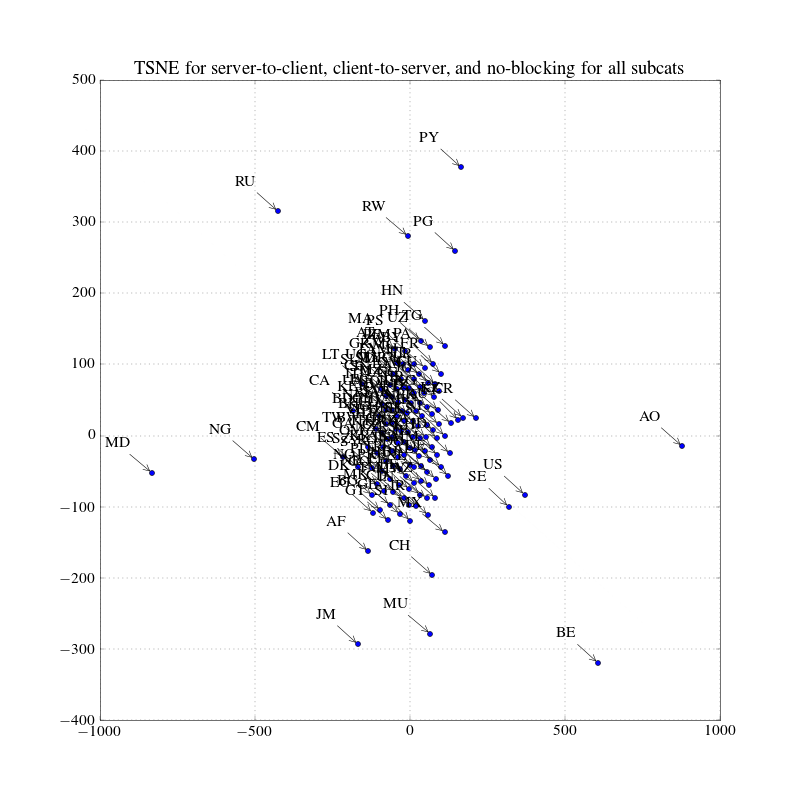

<IPython.core.display.Javascript object>


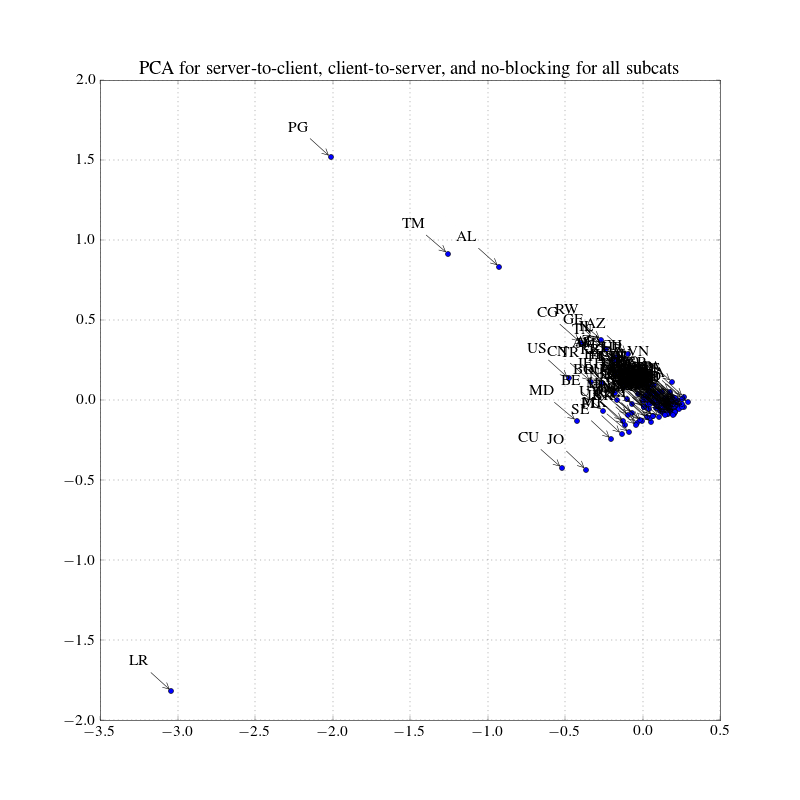

In [108]:
mat = df_multidim2.as_matrix()
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("TSNE for server-to-client, client-to-server, and no-blocking for all subcats")
fig2.savefig(currFolder + "tsne_countries_all_cols")
fig2.show()

mat = df_multidim2.as_matrix()
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA for server-to-client, client-to-server, and no-blocking for all subcats")
fig2.savefig(currFolder + "pca_countries_all_cols")
#fig2.show()
#plt.close()

### This doesn't work due to nans

In [109]:
mat = df_multidim3.as_matrix()
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("TSNE for ratio(server-to-client/total), and no-blocking for all subcats")
fig2.savefig(currFolder + "tsne_countries_ratios")
fig2.show()

mat = df_multidim3.as_matrix()
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA for ratio(server-to-client/total), and no-blocking  for all subcats")
fig2.savefig(currFolder + "pca_countries_ratios")
fig2.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>


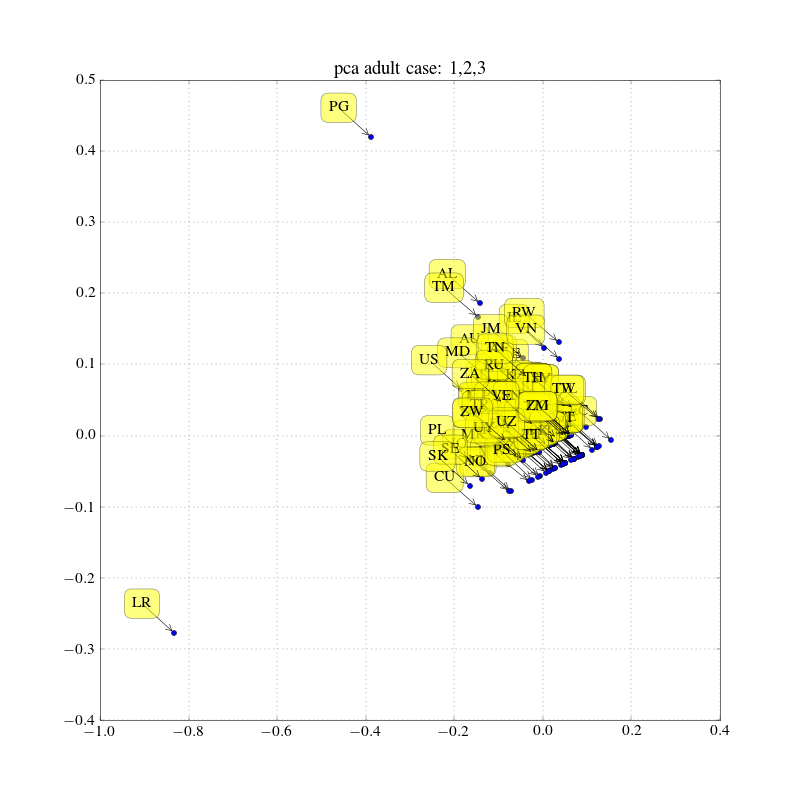

<IPython.core.display.Javascript object>


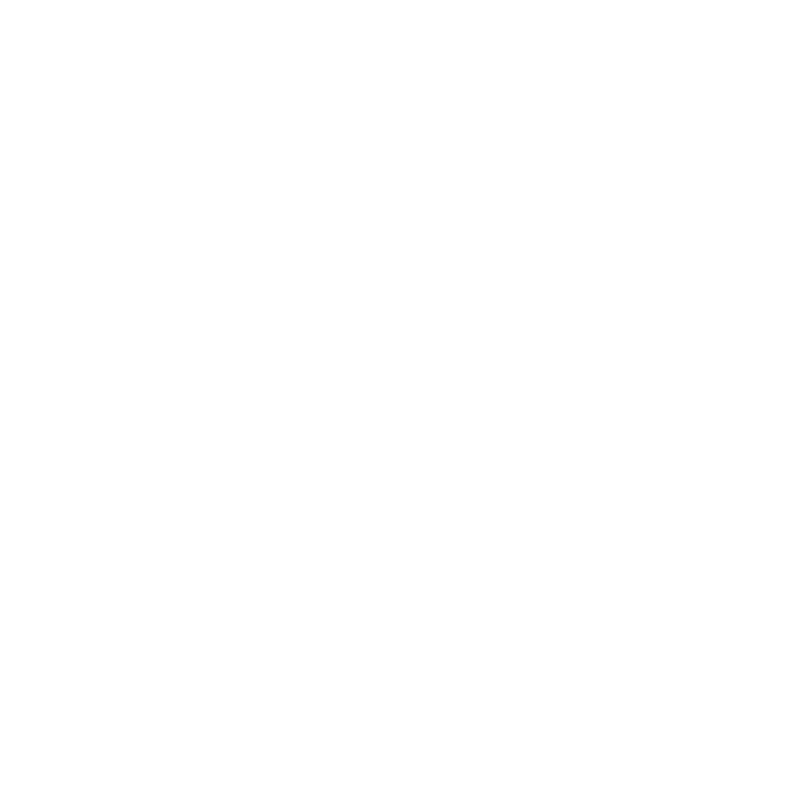

<IPython.core.display.Javascript object>


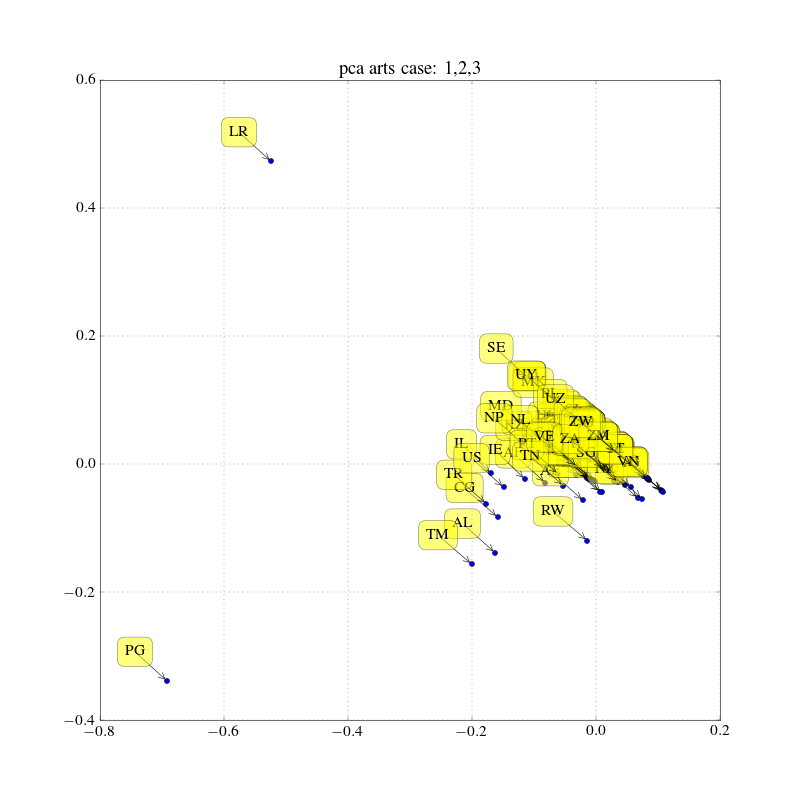

<IPython.core.display.Javascript object>


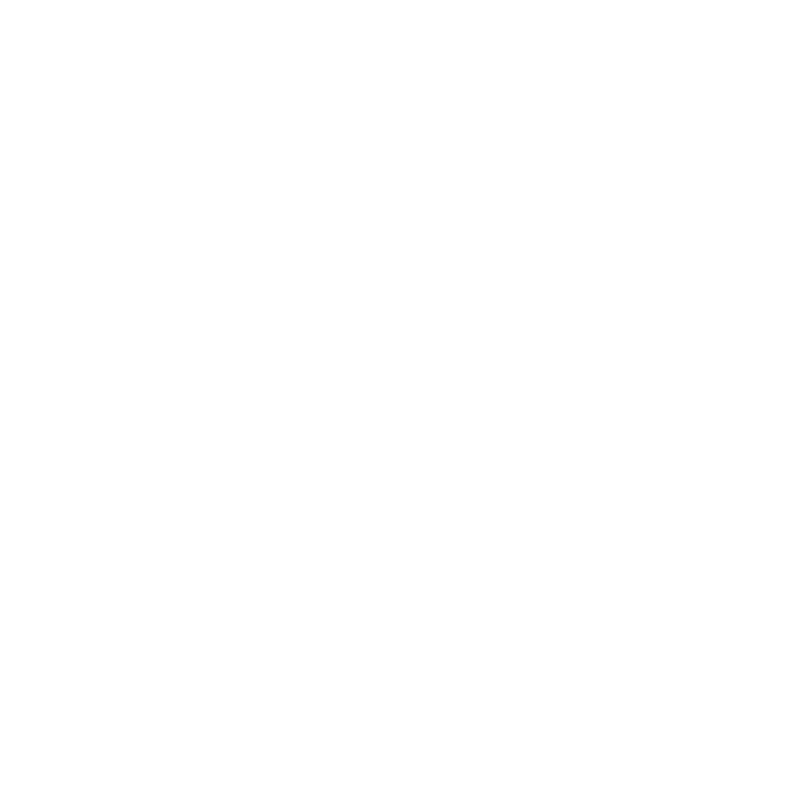

<IPython.core.display.Javascript object>


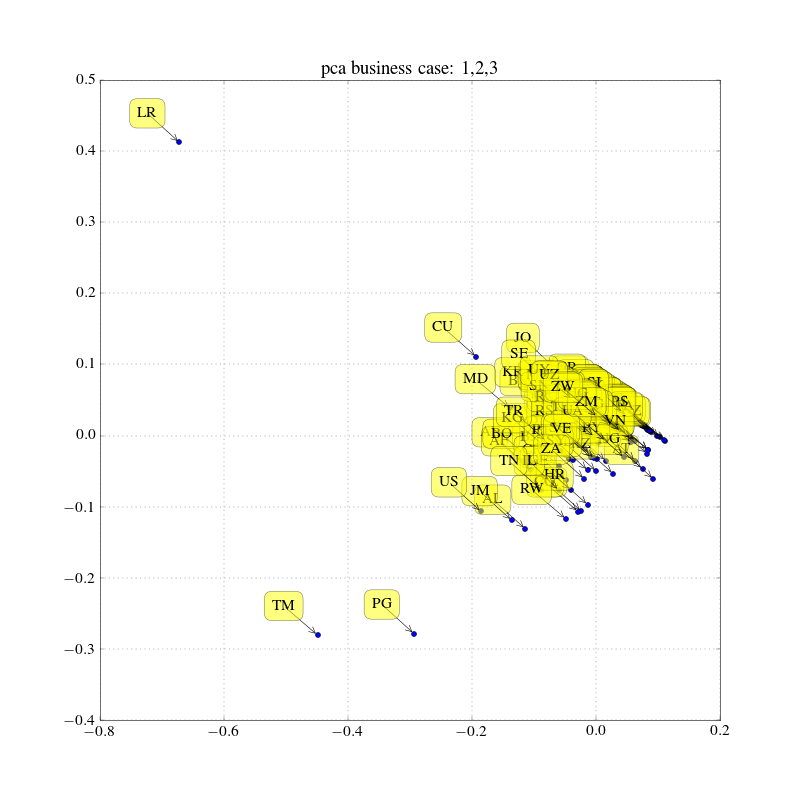

<IPython.core.display.Javascript object>


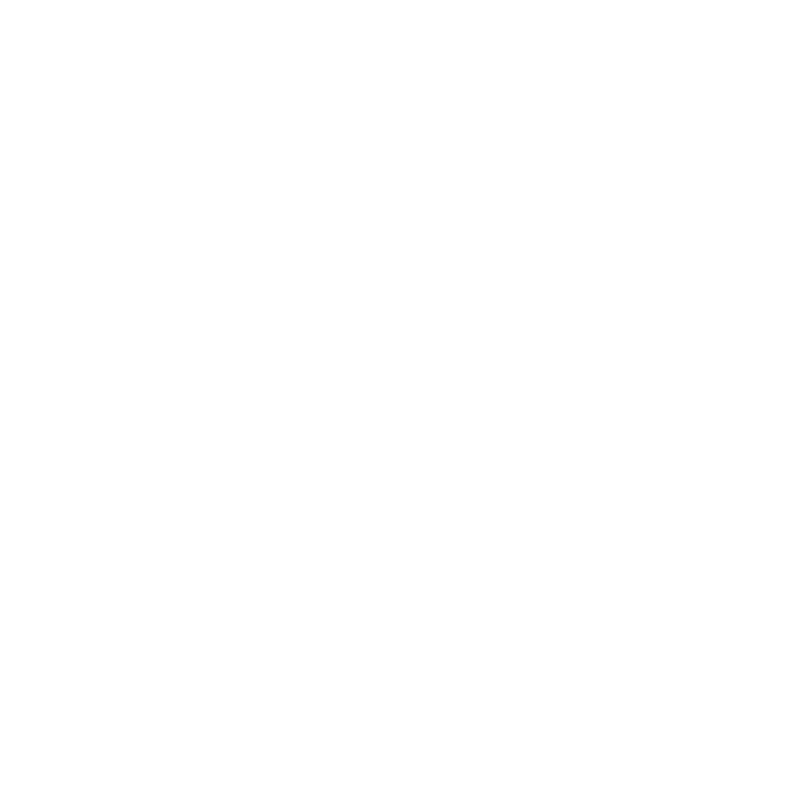

<IPython.core.display.Javascript object>


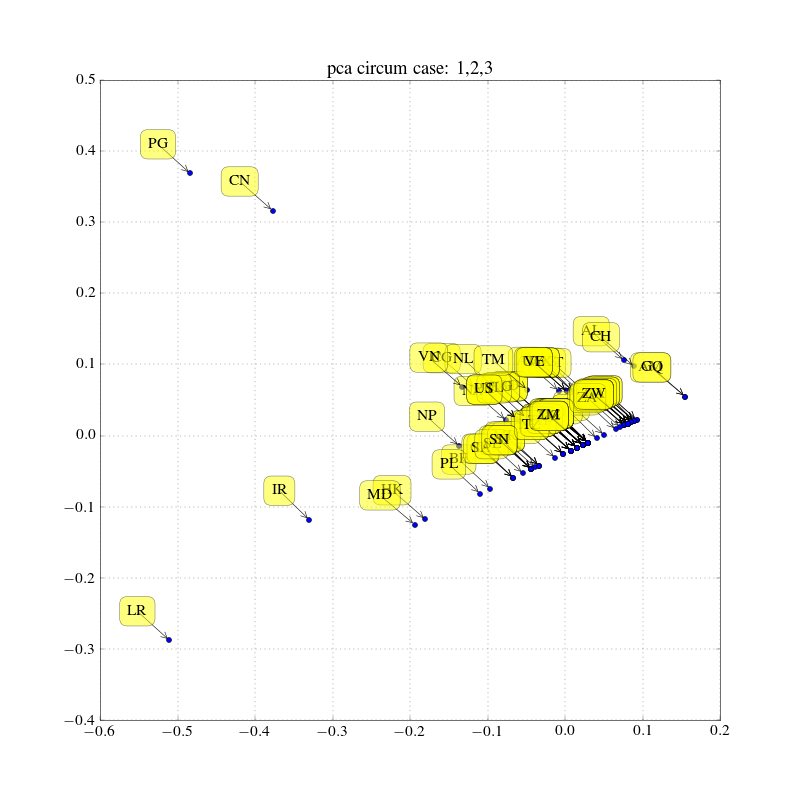

<IPython.core.display.Javascript object>


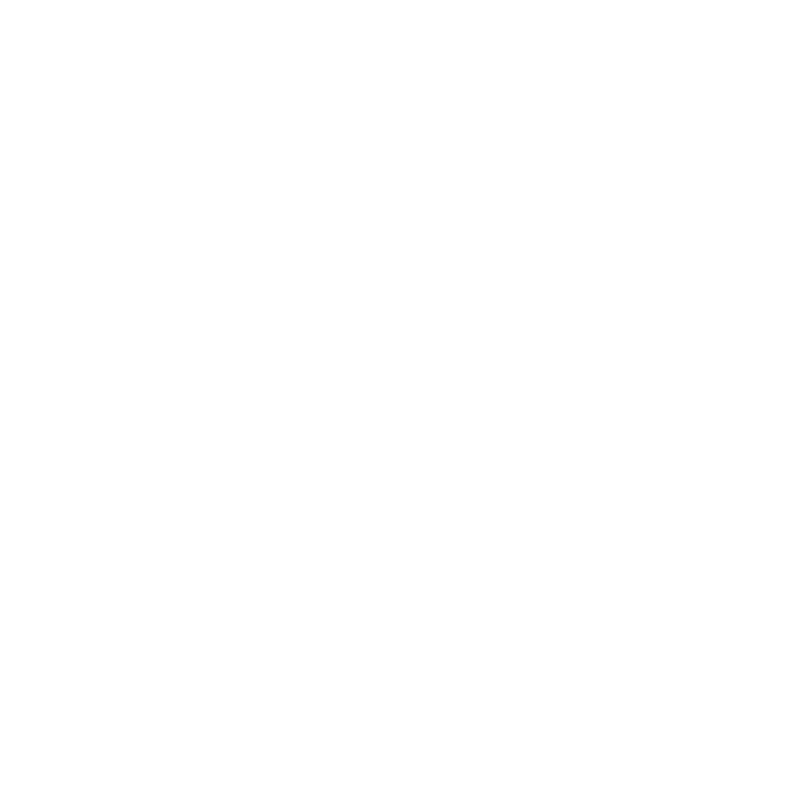

<IPython.core.display.Javascript object>


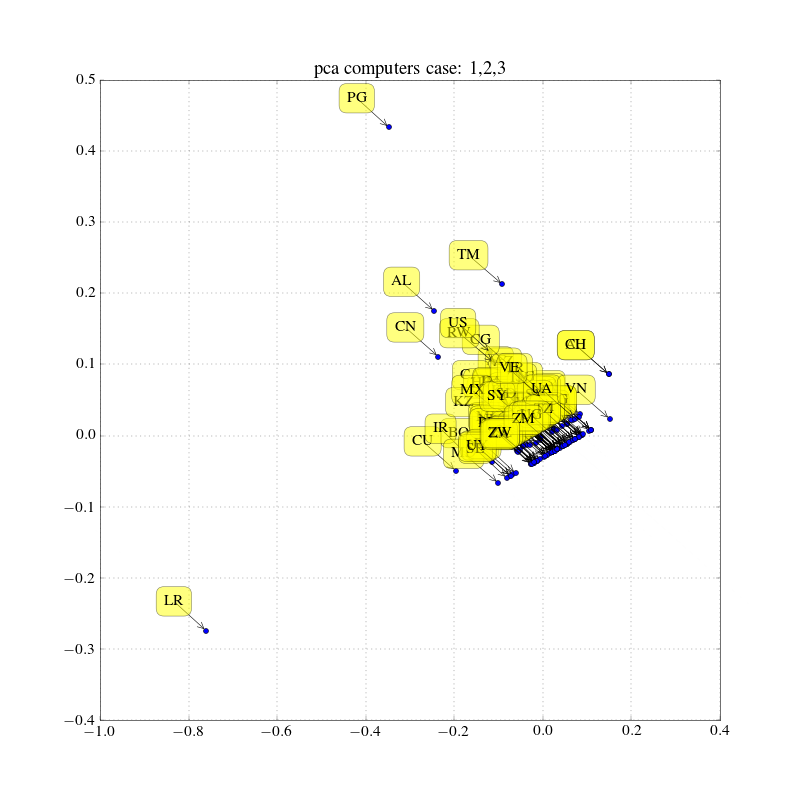

<IPython.core.display.Javascript object>


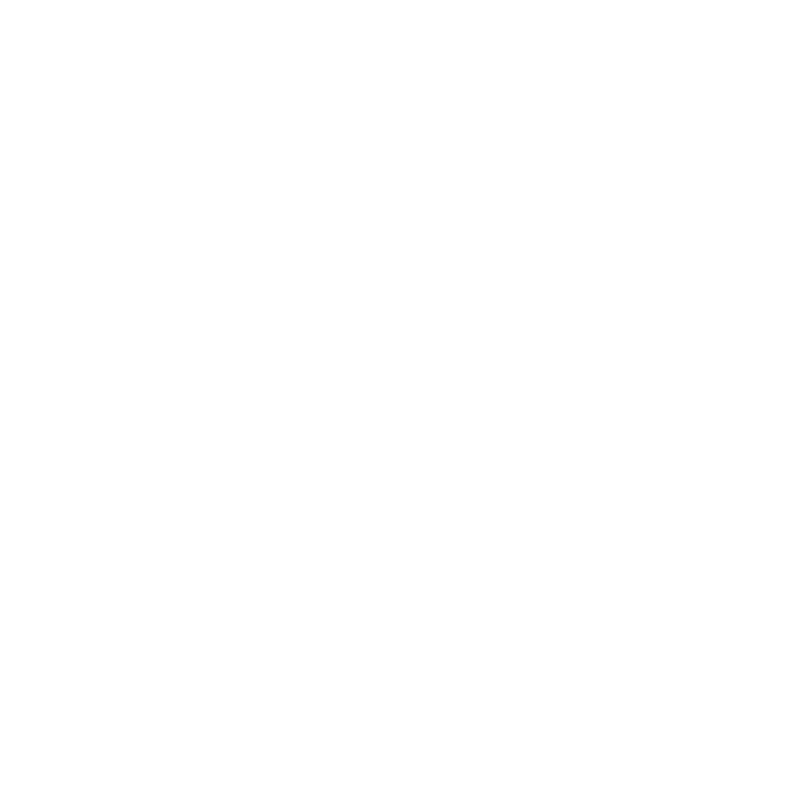

<IPython.core.display.Javascript object>


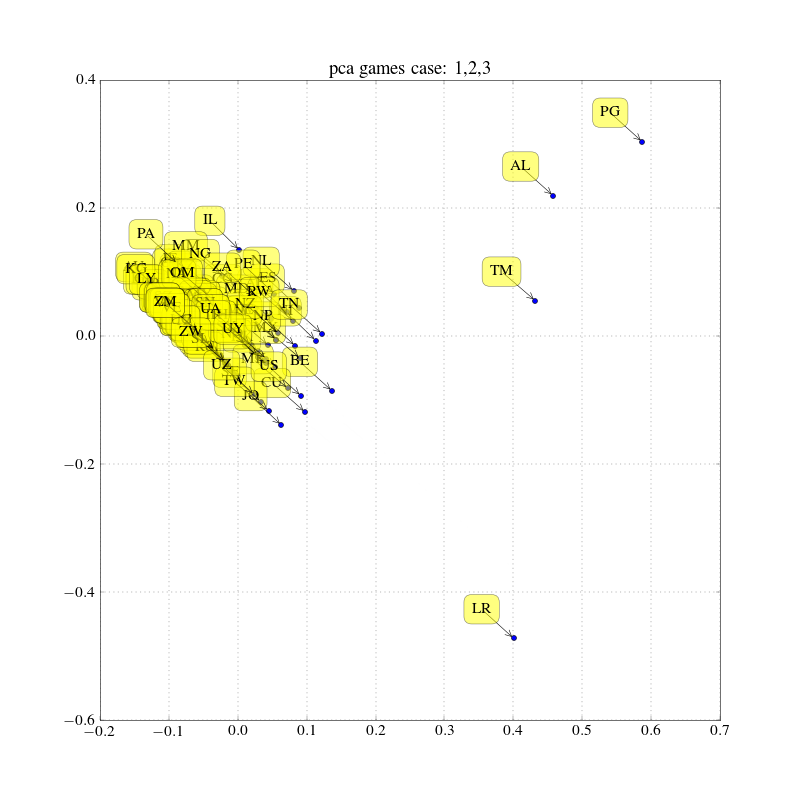

<IPython.core.display.Javascript object>


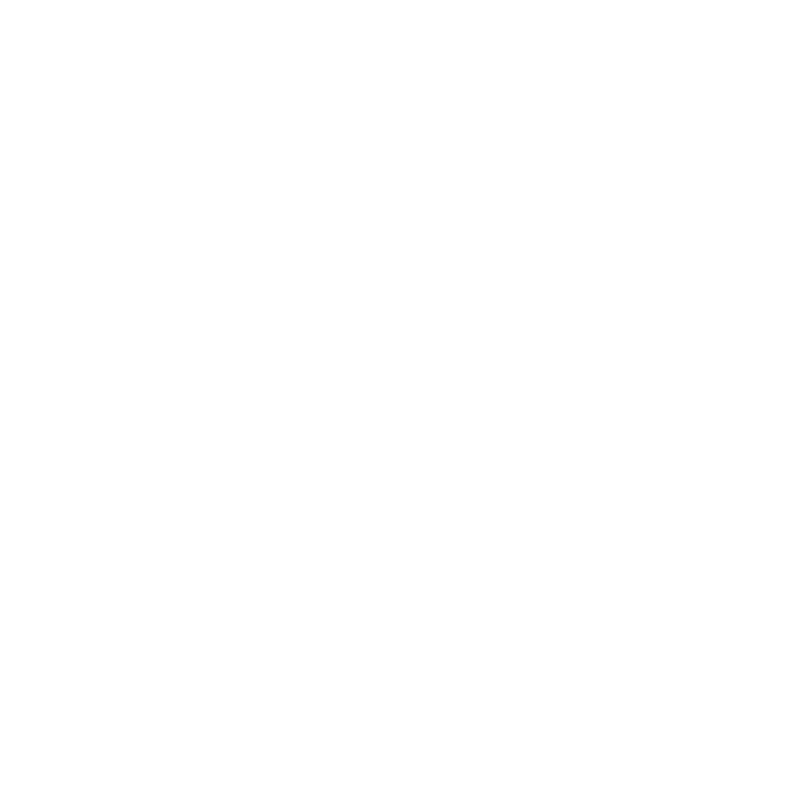

<IPython.core.display.Javascript object>


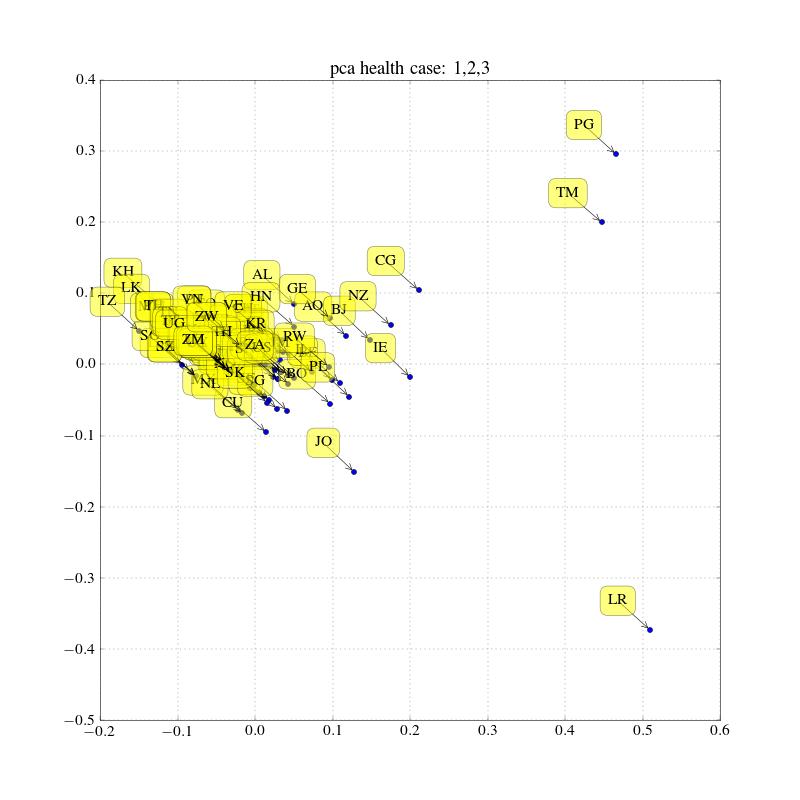

<IPython.core.display.Javascript object>


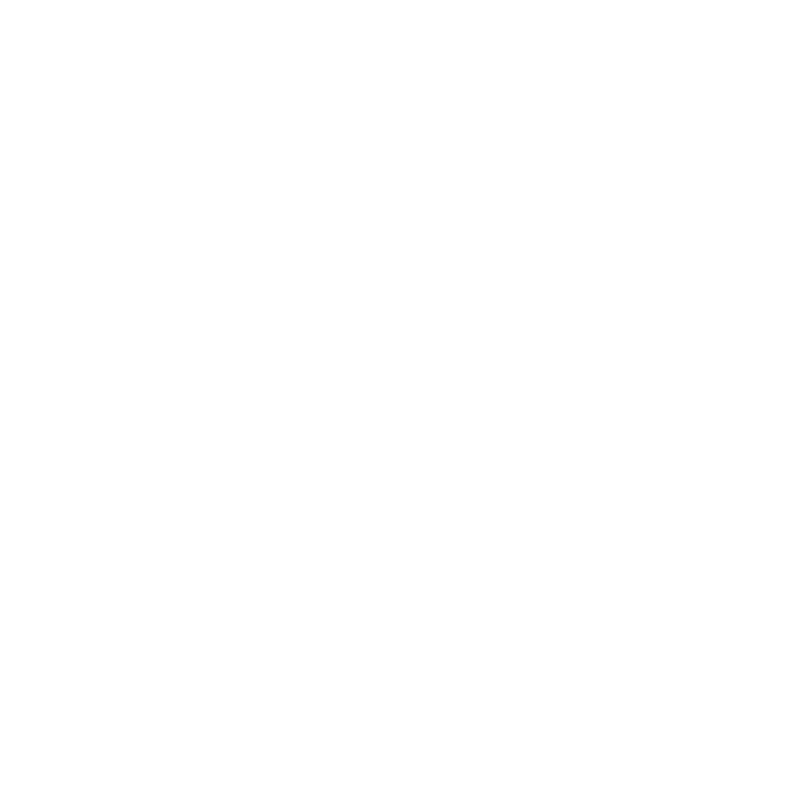

<IPython.core.display.Javascript object>


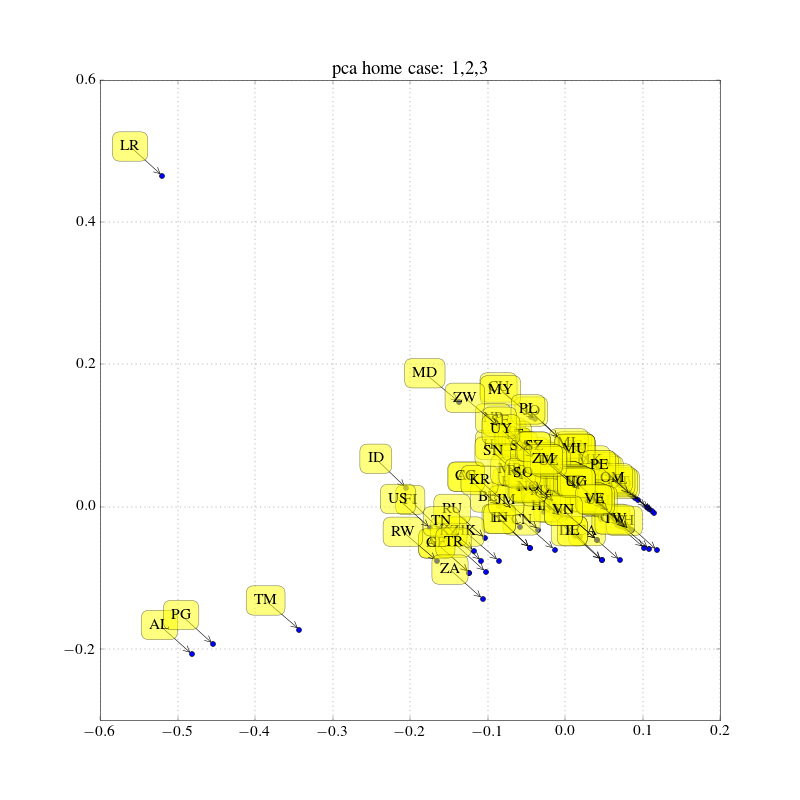

<IPython.core.display.Javascript object>


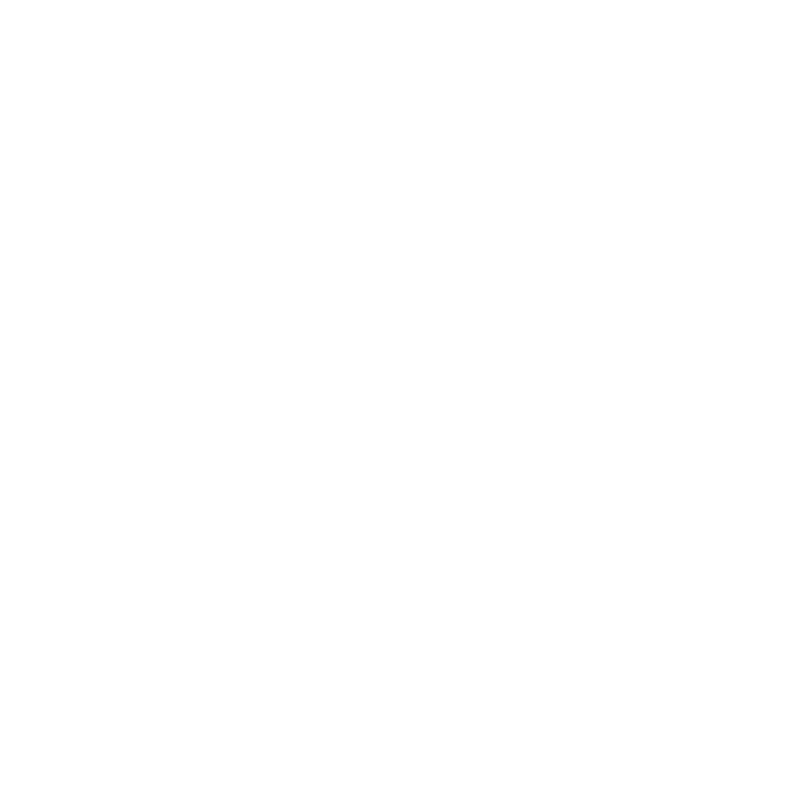

<IPython.core.display.Javascript object>


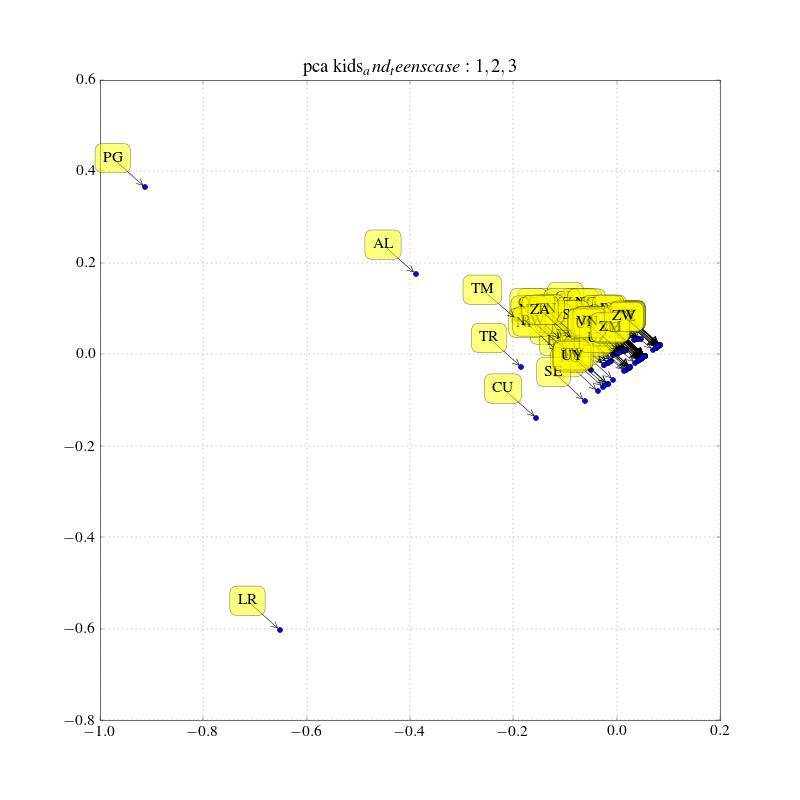

<IPython.core.display.Javascript object>


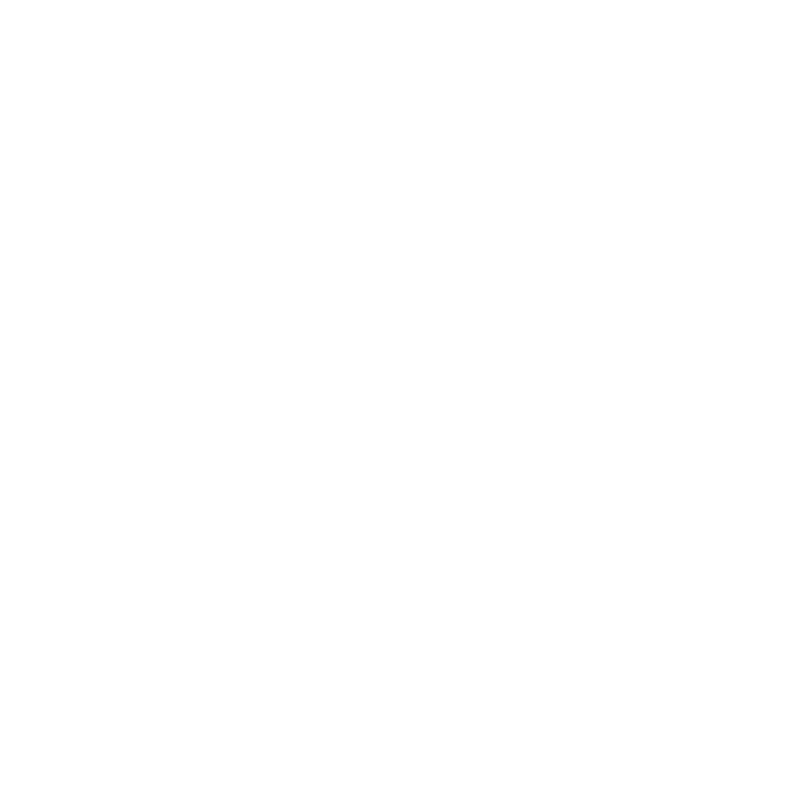

<IPython.core.display.Javascript object>


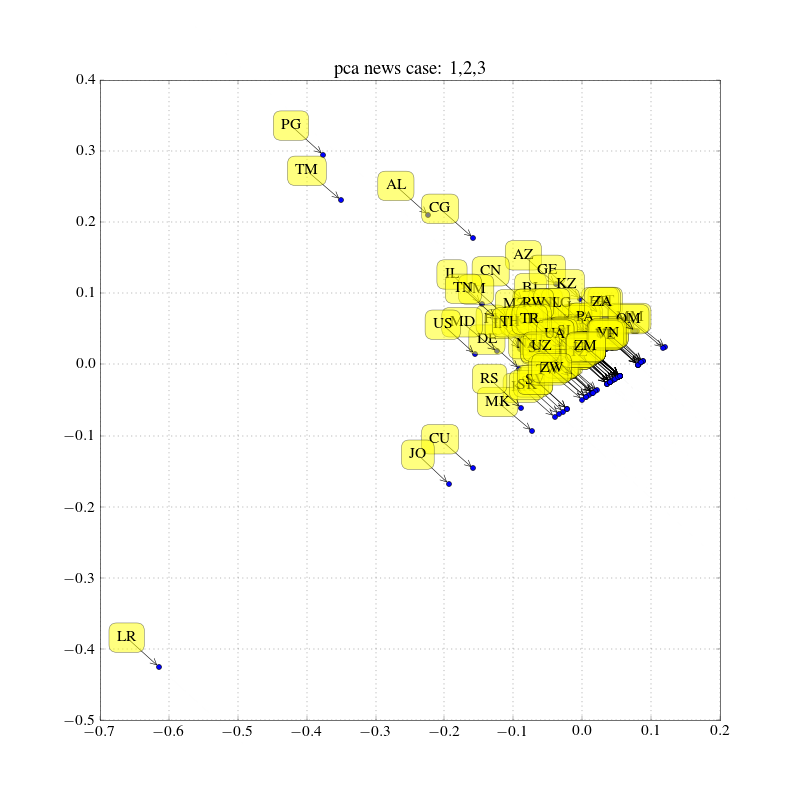

<IPython.core.display.Javascript object>


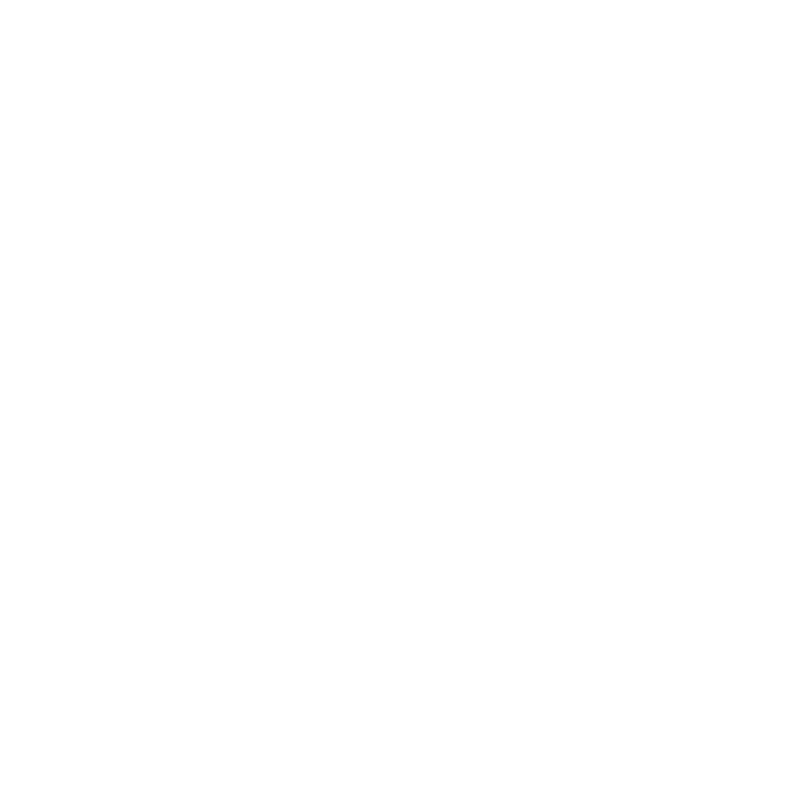

<IPython.core.display.Javascript object>


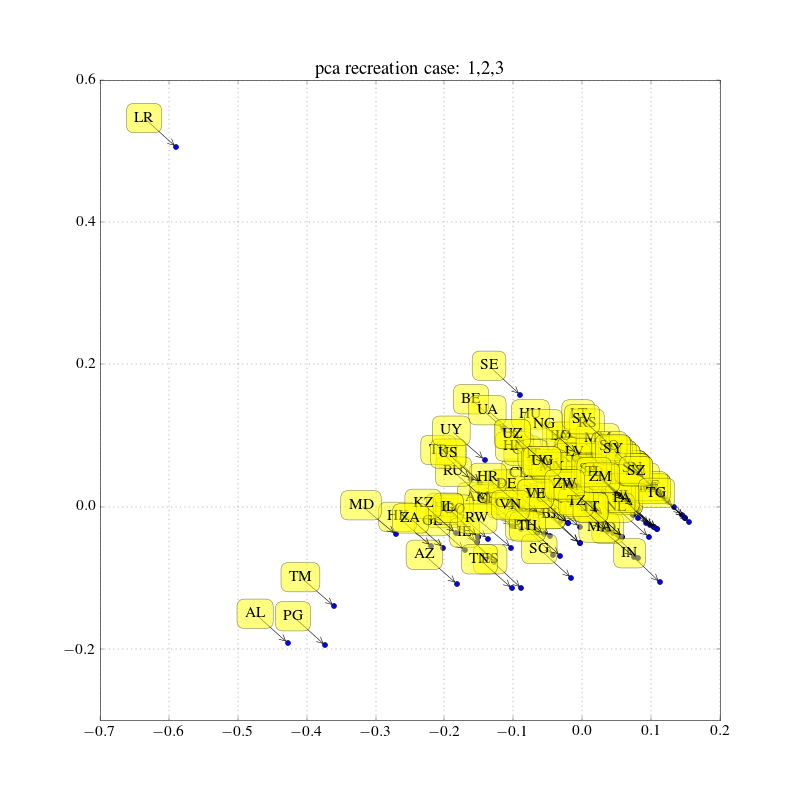

<IPython.core.display.Javascript object>


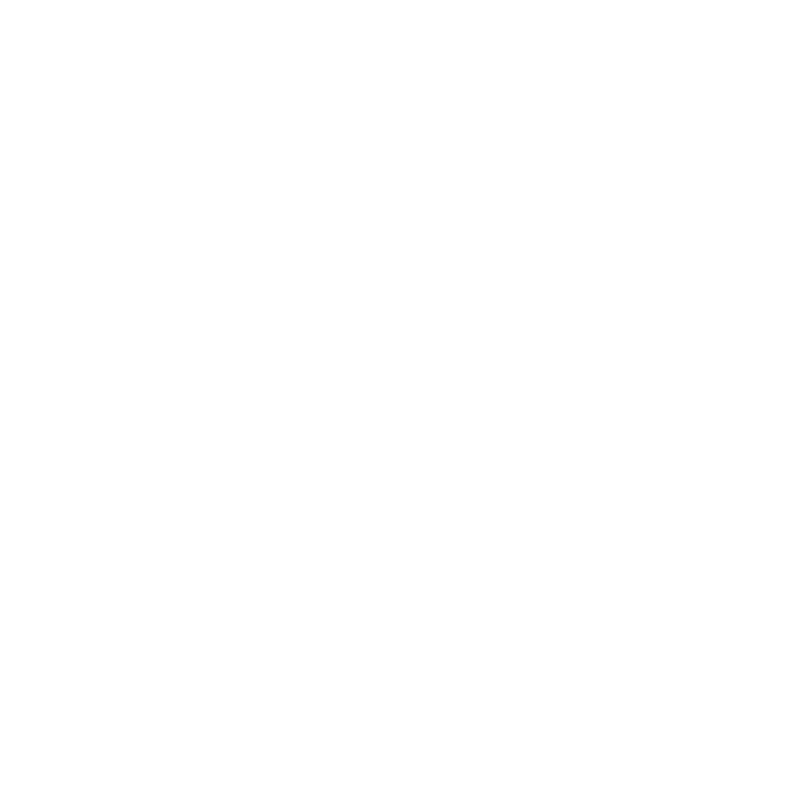

<IPython.core.display.Javascript object>


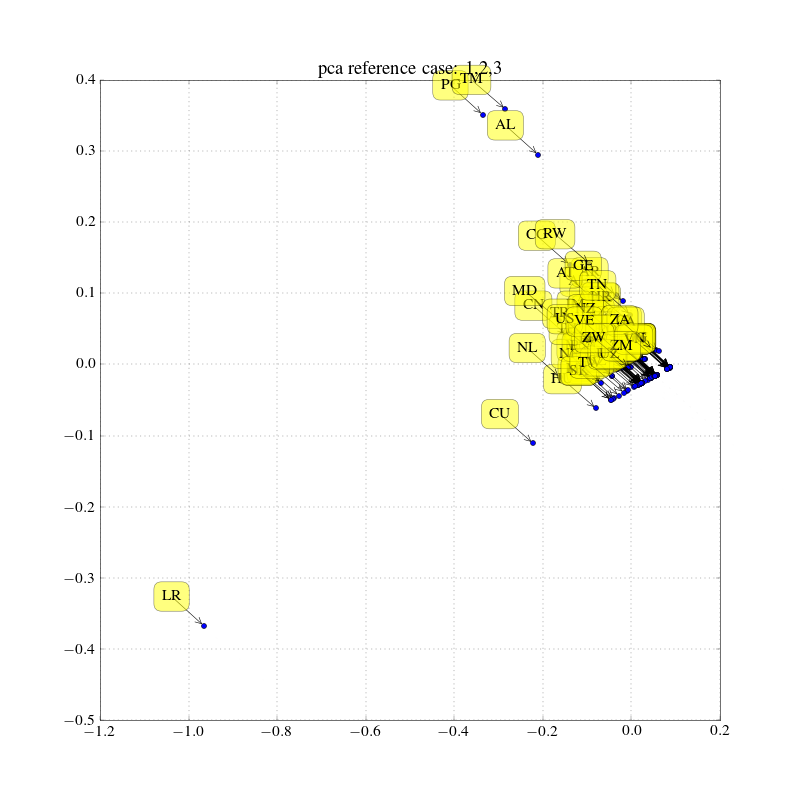

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


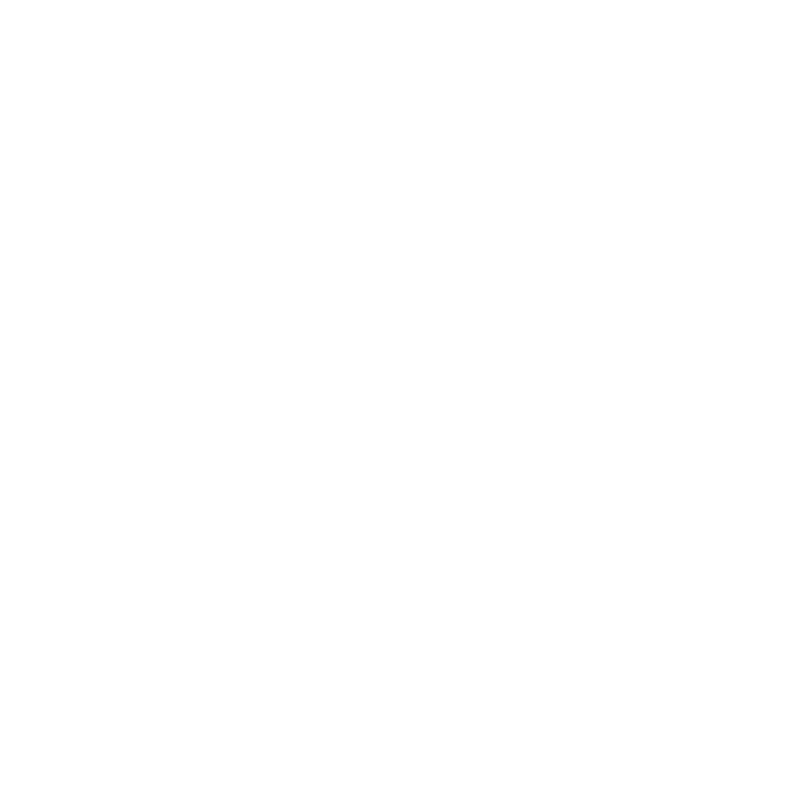

<IPython.core.display.Javascript object>


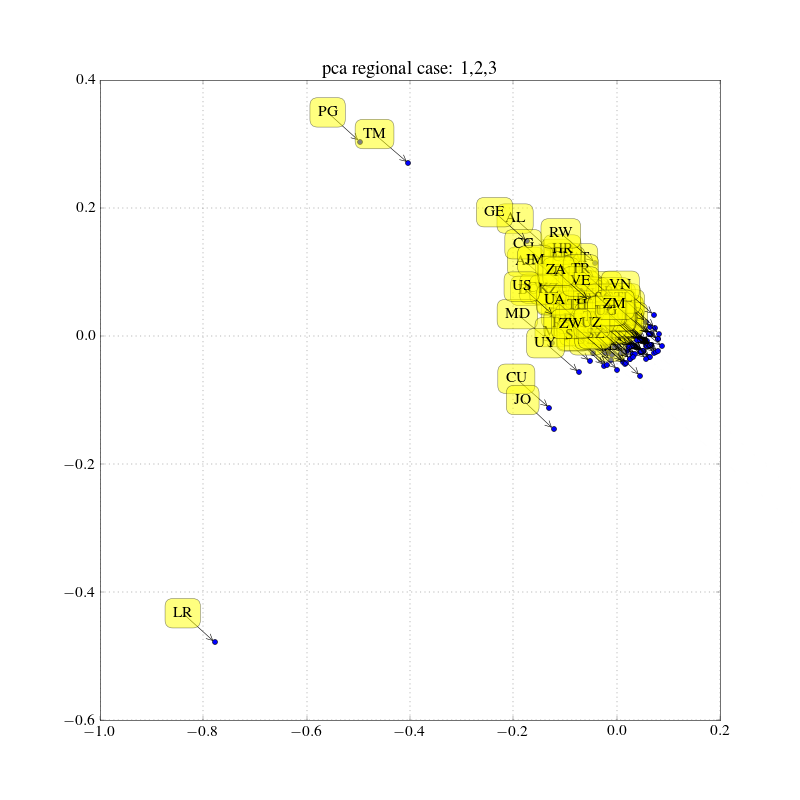

<IPython.core.display.Javascript object>


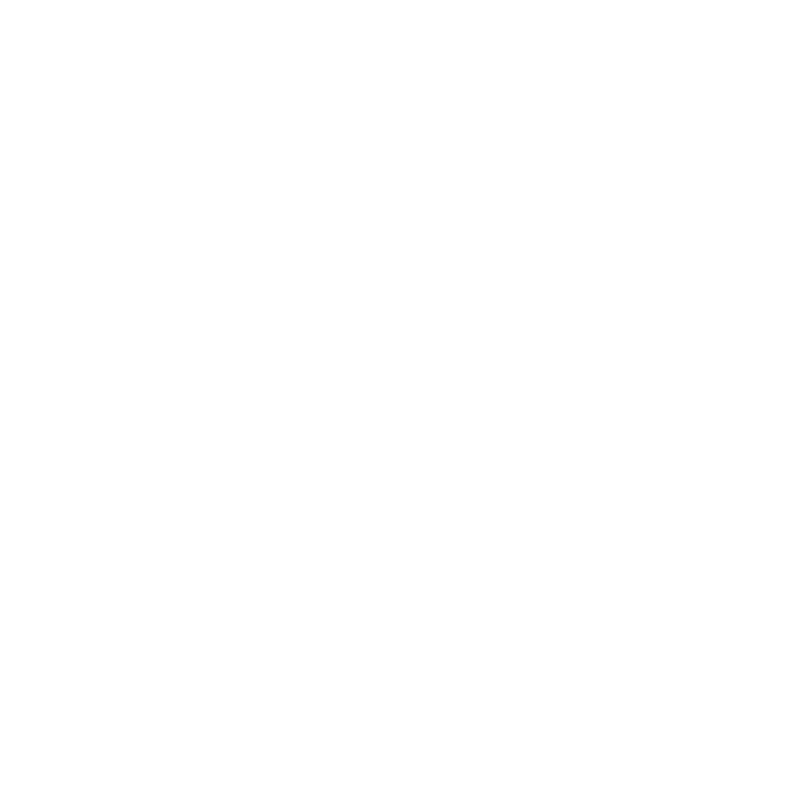

<IPython.core.display.Javascript object>


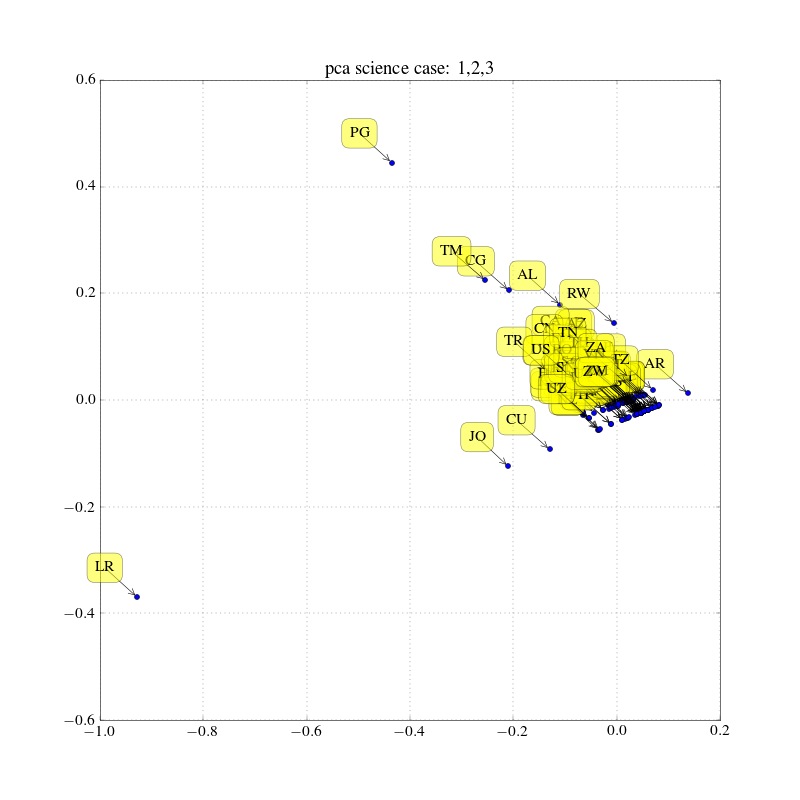

<IPython.core.display.Javascript object>


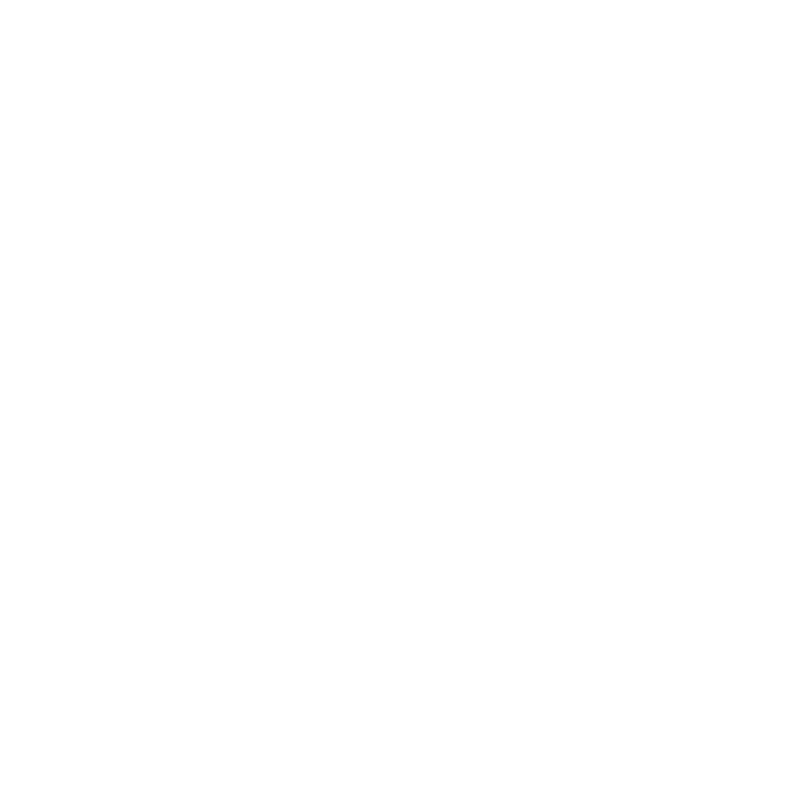

<IPython.core.display.Javascript object>


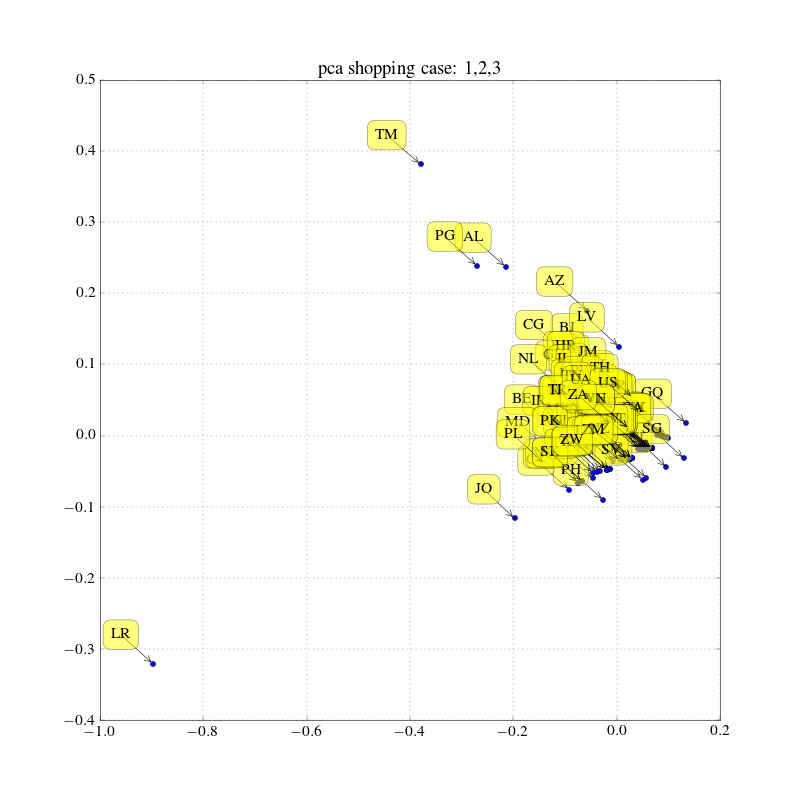

<IPython.core.display.Javascript object>


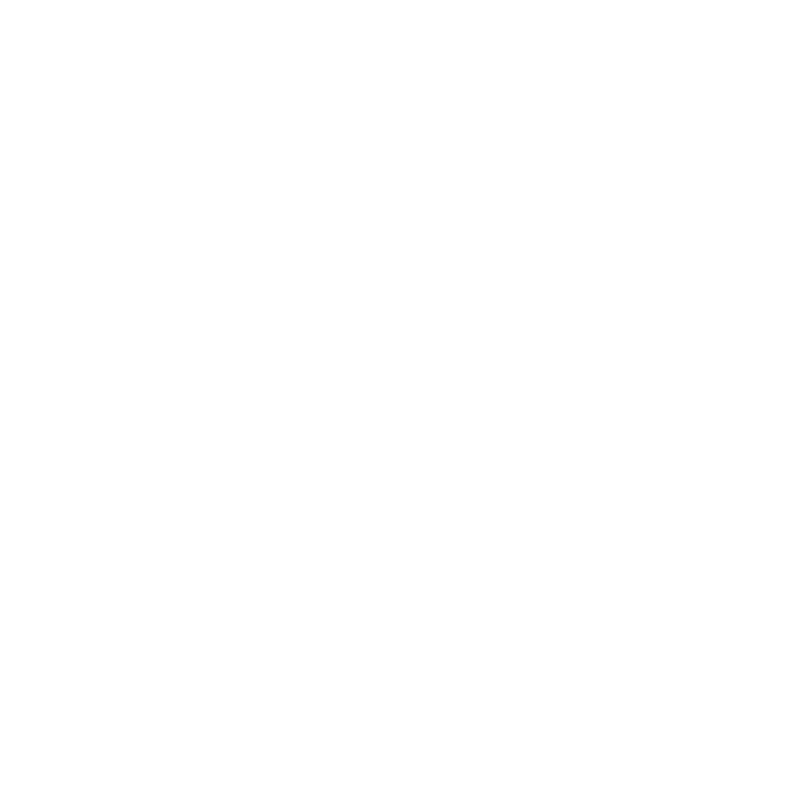

<IPython.core.display.Javascript object>


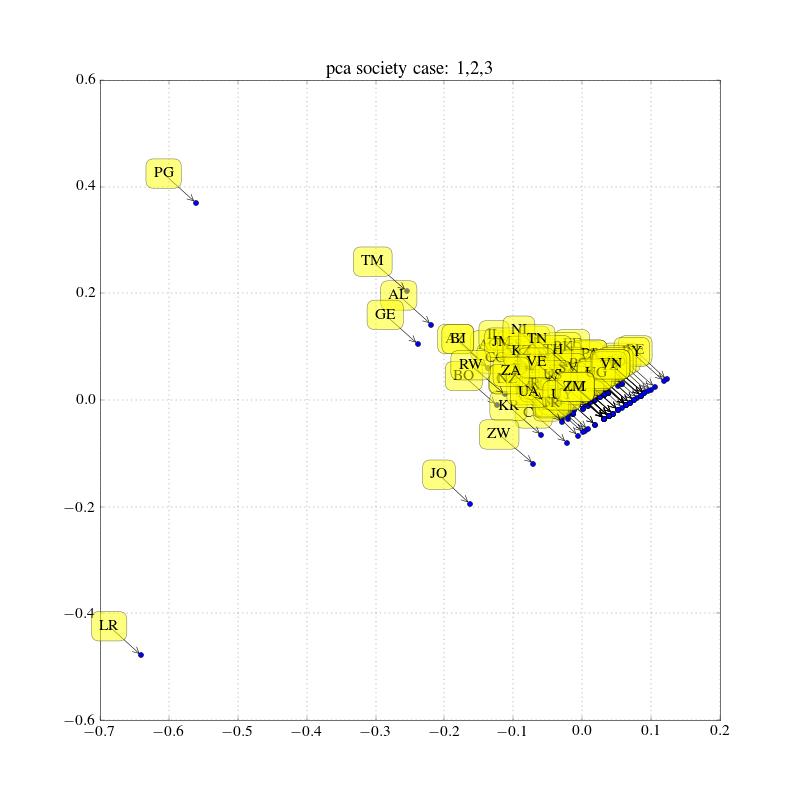

<IPython.core.display.Javascript object>


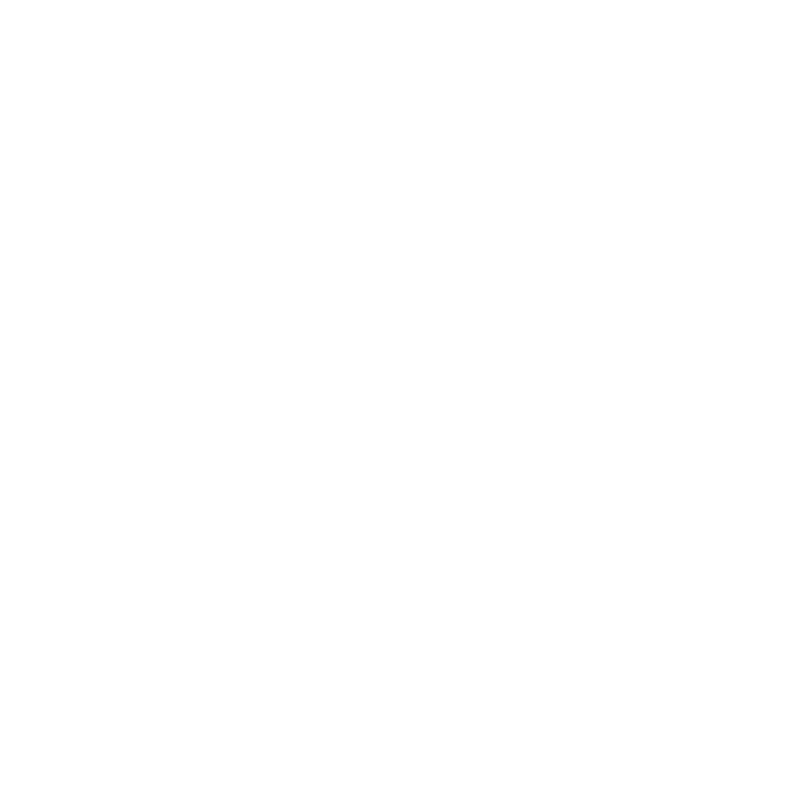

<IPython.core.display.Javascript object>


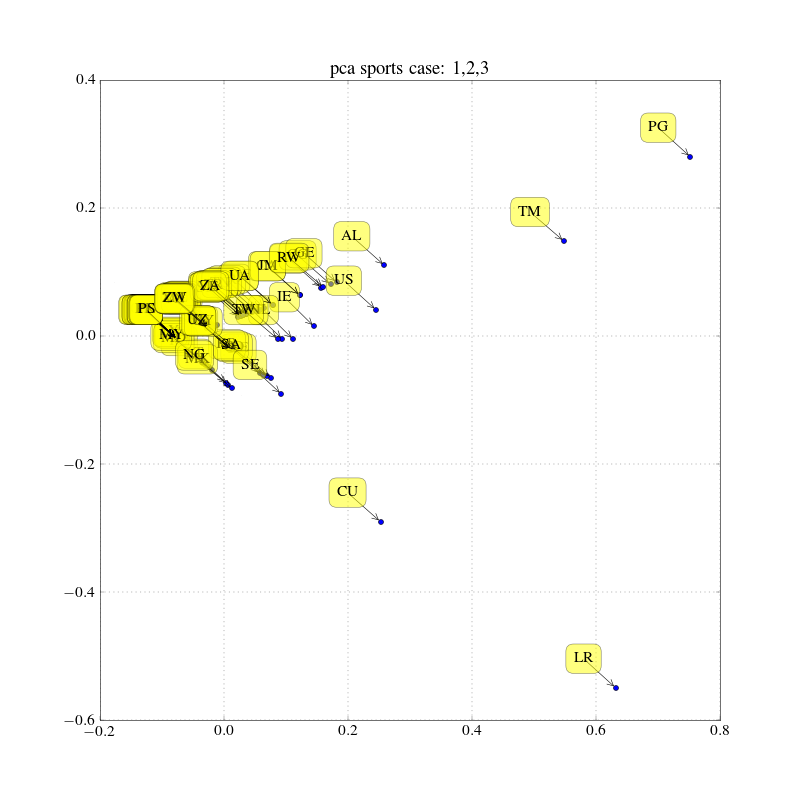

<IPython.core.display.Javascript object>


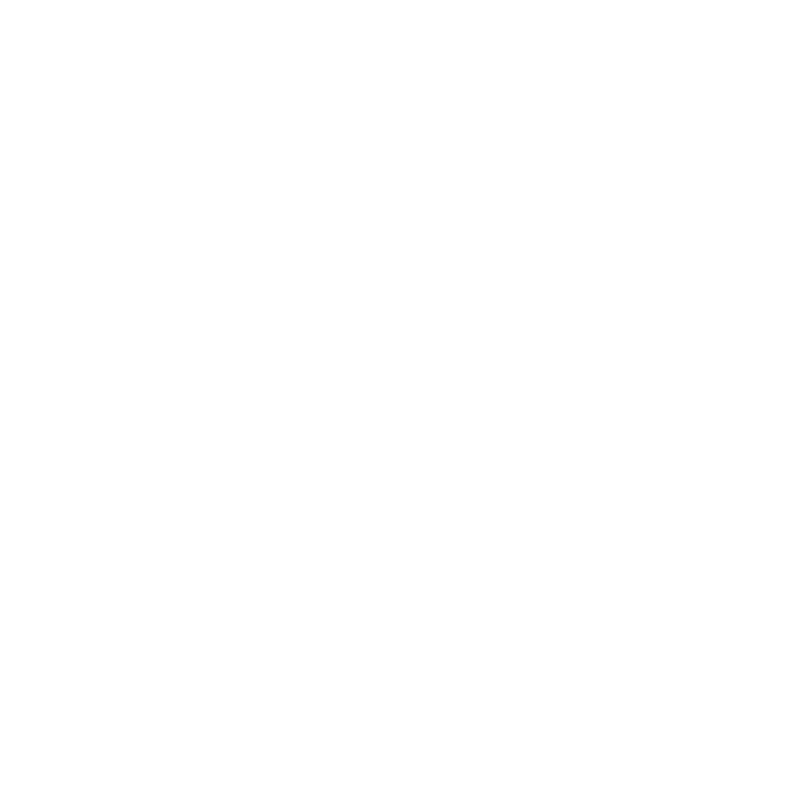

<IPython.core.display.Javascript object>


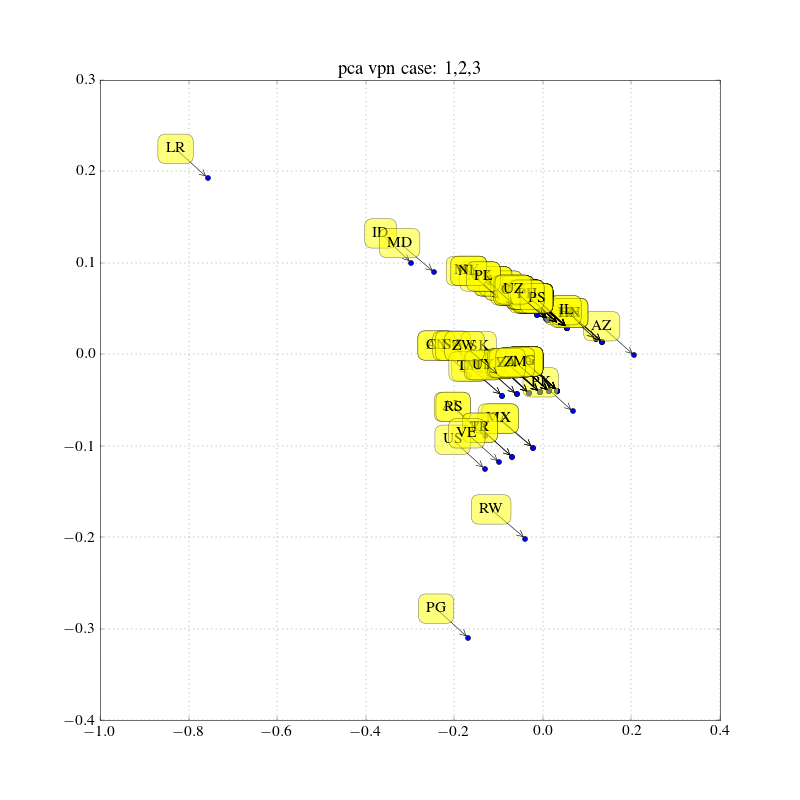

<IPython.core.display.Javascript object>


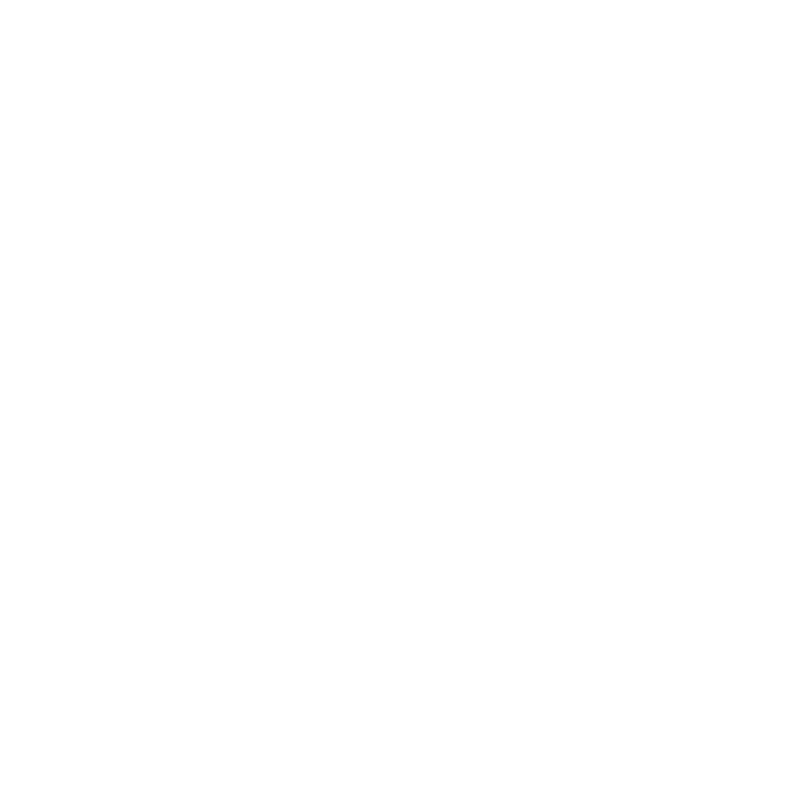

<IPython.core.display.Javascript object>


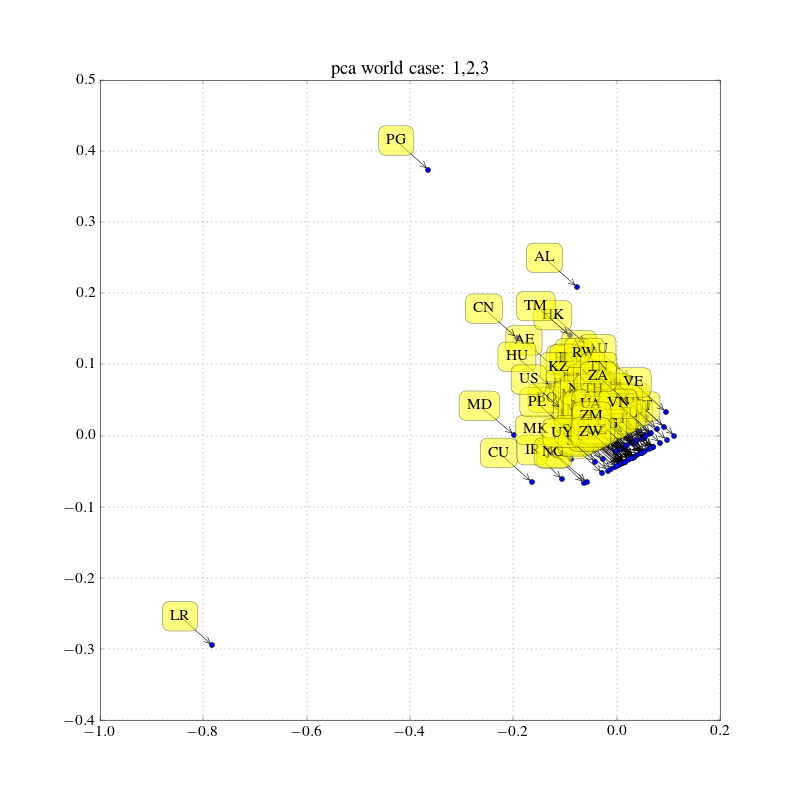

<IPython.core.display.Javascript object>


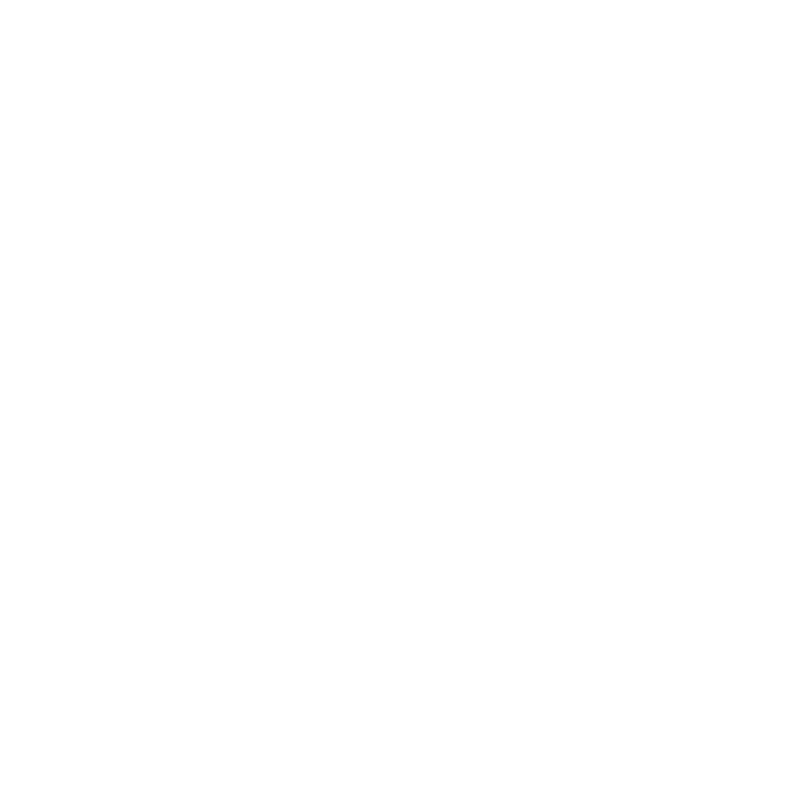

In [110]:
#subcat = 'adult'

for subcat in df_censorship.subcat.unique():
    df = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case2','case3']]
    mat = df.as_matrix()
    df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df.index)

    model = 'pca'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4[0], df4[1])
    for label, x, y in zip(df4.index, df4[0], df4[1]):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' case: 1,2,3')
    ax2.grid(1)
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)

    model = 'tsne'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4[0], df4[1])
    for label, x, y in zip(df4.index, df4[0], df4[1]):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' case: 1,2,3')
    ax2.grid(1)
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)

    plt.close()
#df_multidim = df.pivot(index='country', columns='subcat')

In [111]:
df_censorship.head()

case country     subcat  1   2  3  total     case1     case2     case3  \
0         AE      adult  3  24  3     30  0.100000  0.800000  0.100000   
1         AE       arts  3  35  2     40  0.075000  0.875000  0.050000   
2         AE   business  4  25  6     35  0.114286  0.714286  0.171429   
3         AE     circum  1  13  1     15  0.066667  0.866667  0.066667   
4         AE  computers  2  26  8     36  0.055556  0.722222  0.222222   

case    case13  case1/case13  
0     0.200000           0.5  
1     0.125000           0.6  
2     0.285714           0.4  
3     0.133333           0.5  
4     0.277778           0.2

In [112]:
df_global = df_censorship.groupby('subcat')[['1','2','3', 'total']].sum()
df_global['1'] = df_global['1']/df_global['total']
df_global['2'] = df_global['2']/df_global['total']
df_global['3'] = df_global['3']/df_global['total']
df_global = df_global[['1','2','3']]

## GLOBAL - ignore country

<IPython.core.display.Javascript object>


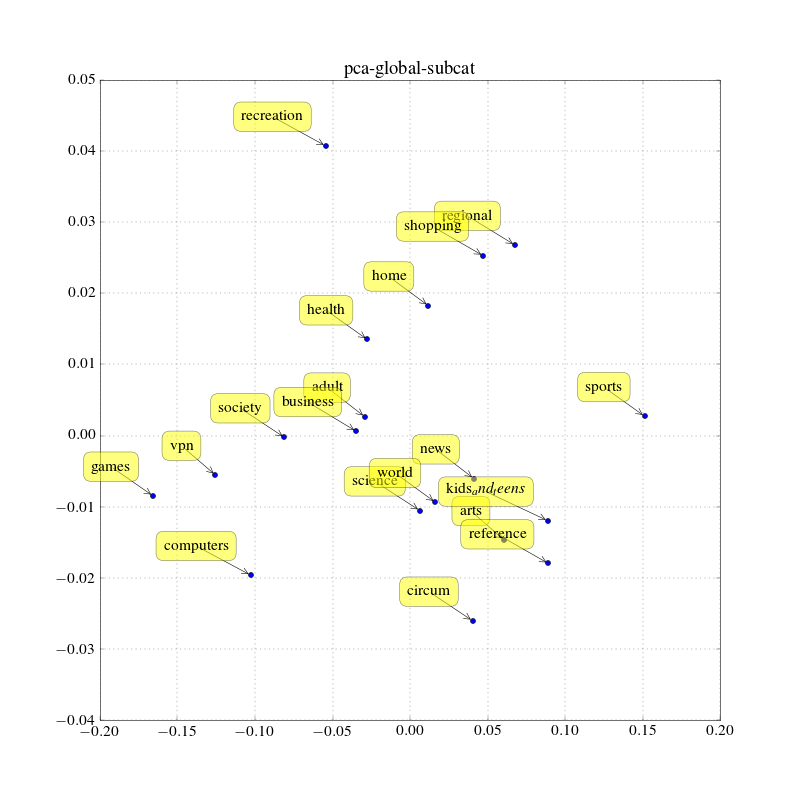

<IPython.core.display.Javascript object>


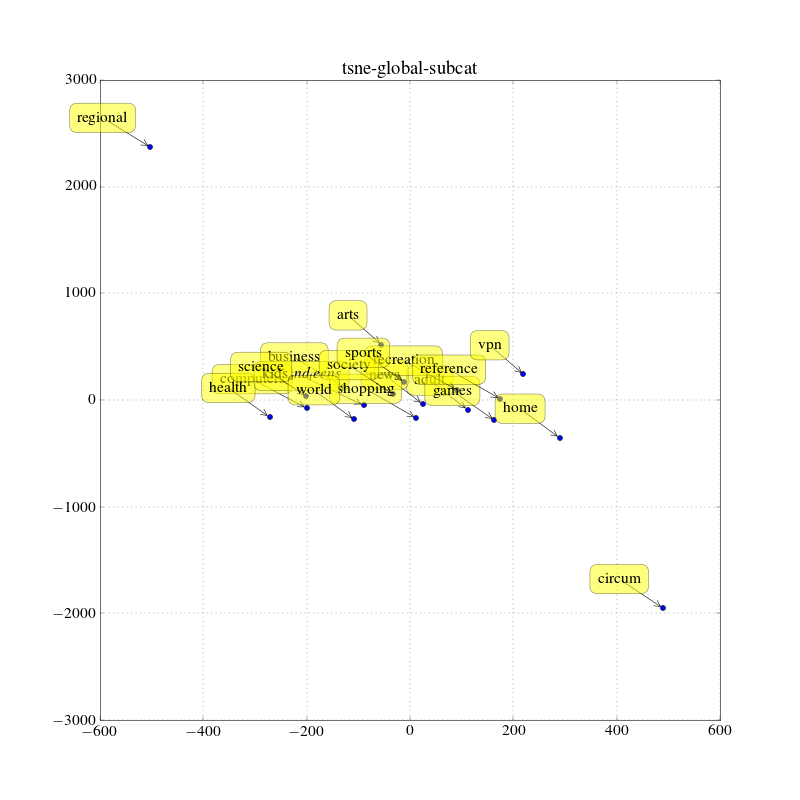

In [113]:
mat = df_global.as_matrix()

model = 'pca'
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_global.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title(model + '-global-subcat')
fig2.savefig(RESULTS + model + '-global-subcat')

model = 'tsne'
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_global.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title(model + '-global-subcat')
fig2.savefig(RESULTS + model + '-global-subcat')

# SCATTER PLOTS PER SUBCAT

<IPython.core.display.Javascript object>


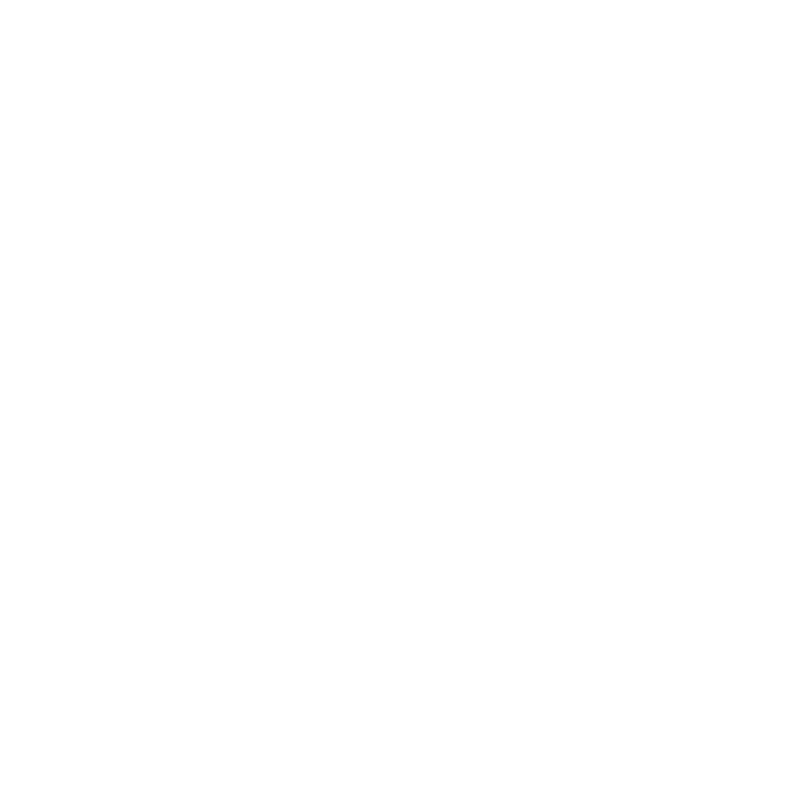

<IPython.core.display.Javascript object>


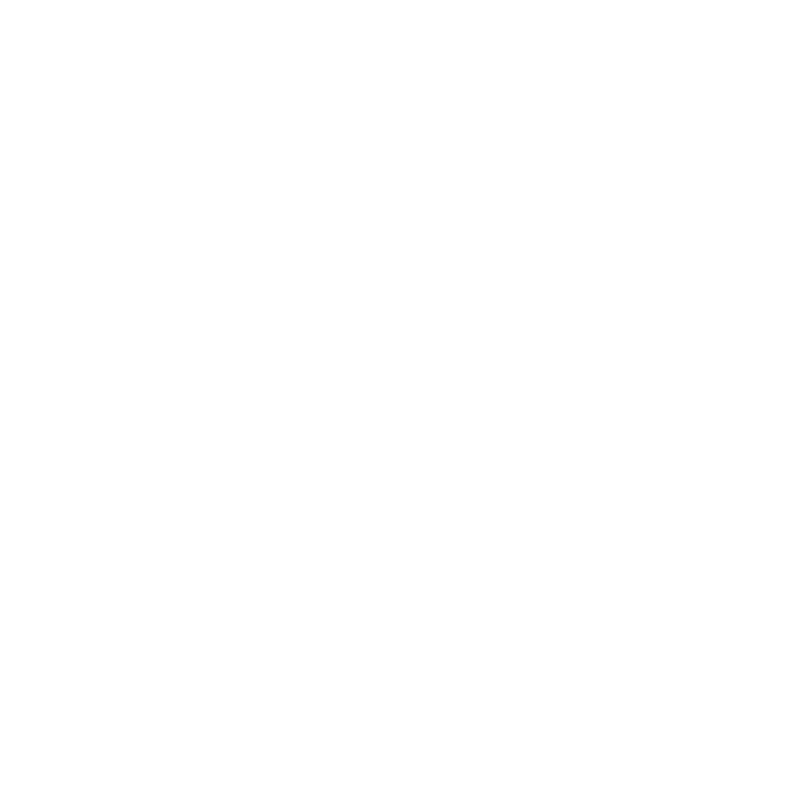

<IPython.core.display.Javascript object>


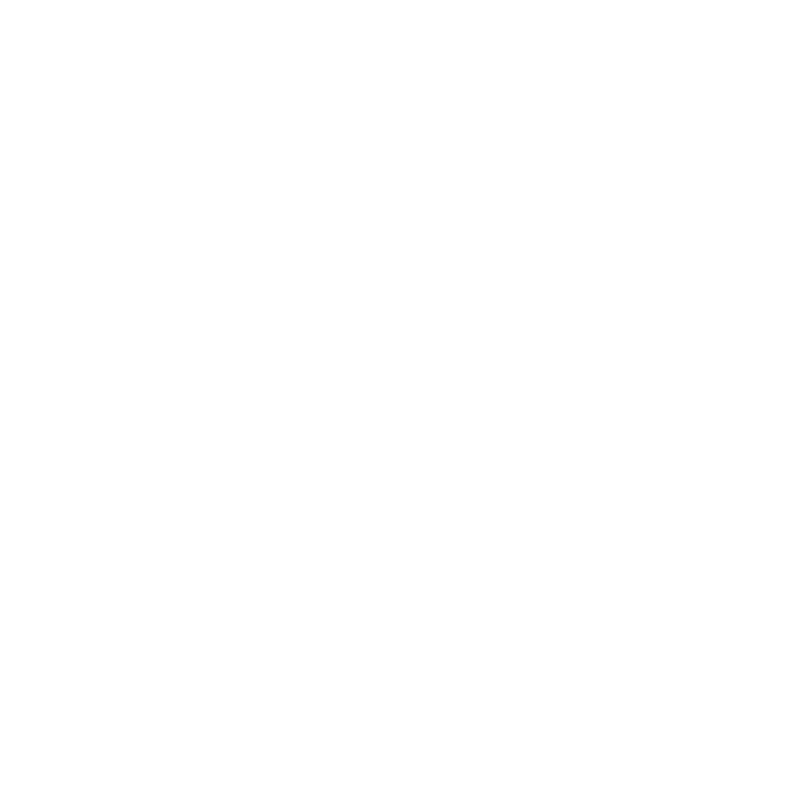

<IPython.core.display.Javascript object>


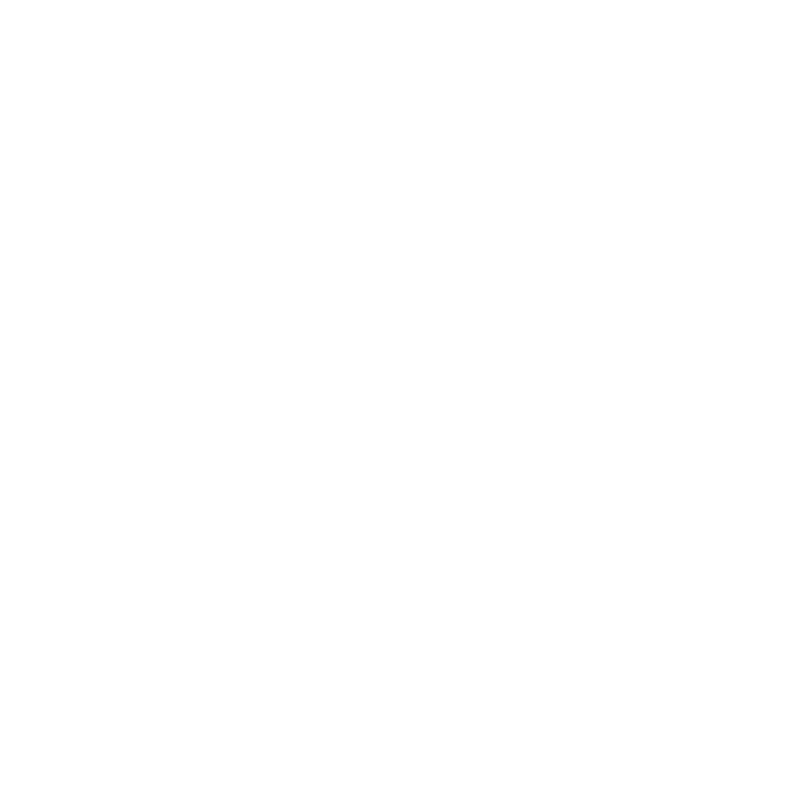

<IPython.core.display.Javascript object>


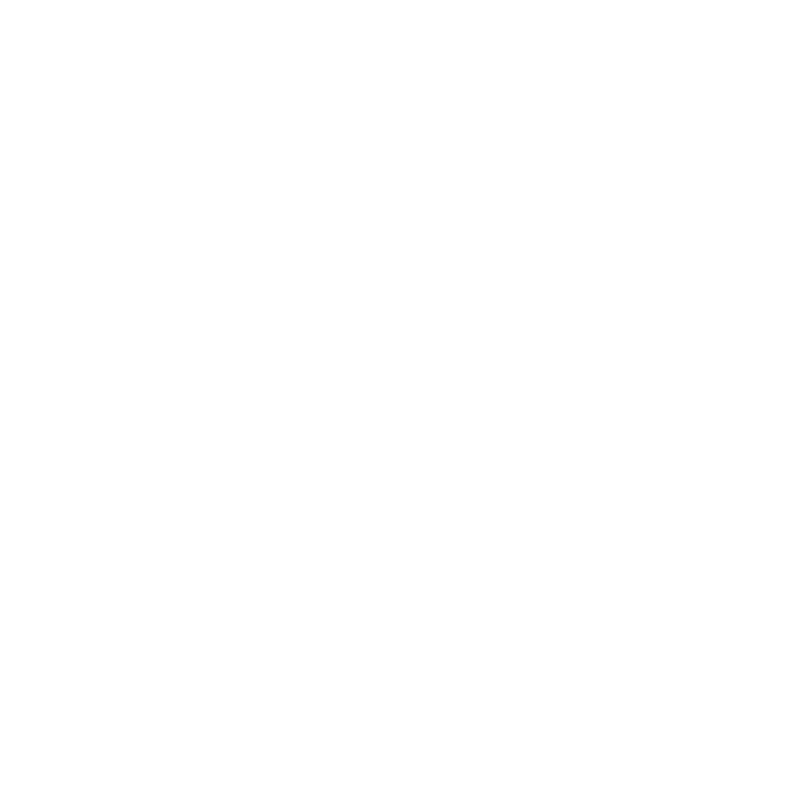

<IPython.core.display.Javascript object>


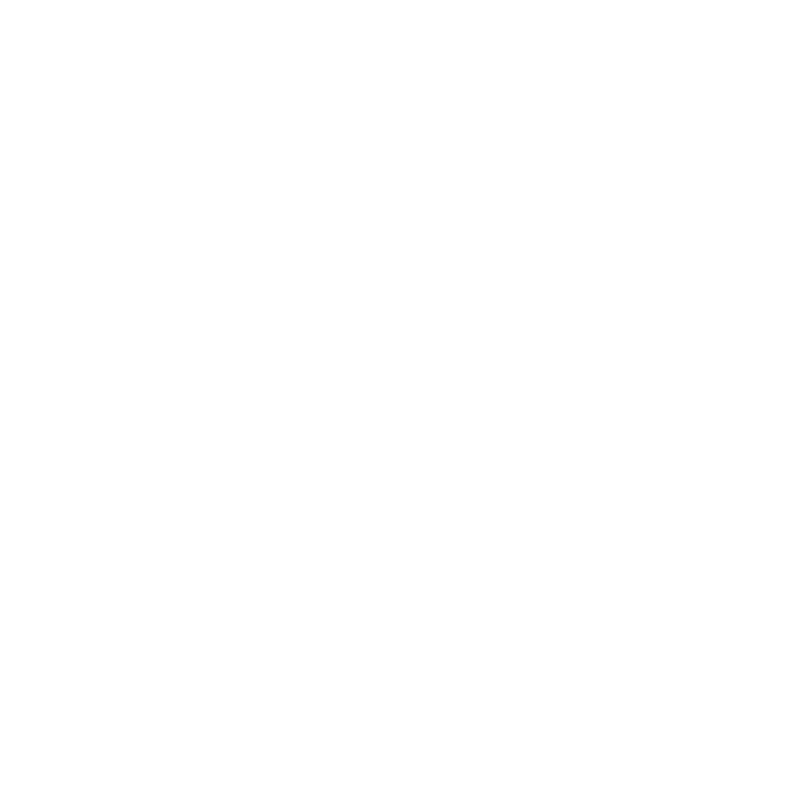

<IPython.core.display.Javascript object>


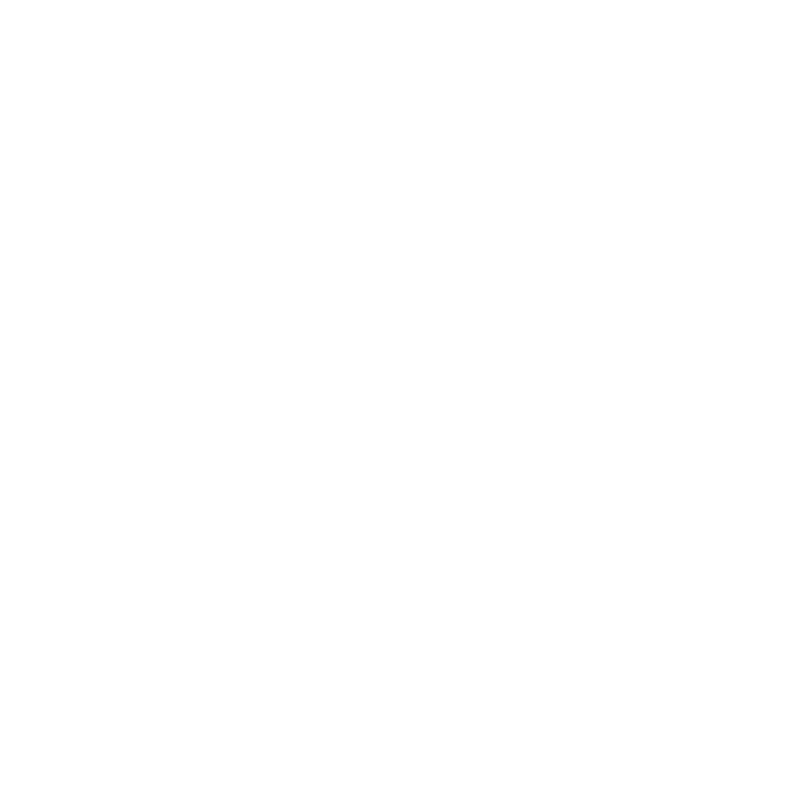

<IPython.core.display.Javascript object>


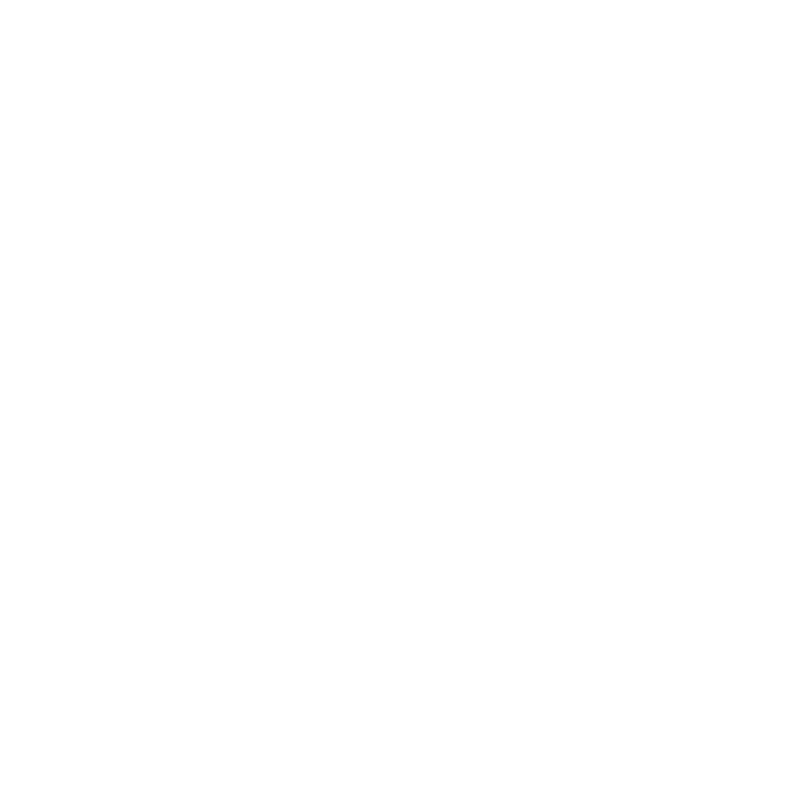

<IPython.core.display.Javascript object>

RuntimeError: LaTeX was not able to process the following string:
'scatter kids_and_teens TCP/IP blocking case 1 vs case 3'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./e1ecc379ec458160948f8ae0bdb266db.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file e1ecc379ec458160948f8ae0bdb266db.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...800000}{21.000000}{\rmfamily scatter kids_
                                                  and_teens TCP/IP blocking ...

(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omlztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omsztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omxztmcm.fd)
! Extra }, or forgotten $.
l.12 ...nd_teens TCP/IP blocking case 1 vs case 3}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./e1ecc379ec458160948f8ae0bdb266db.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on e1ecc379ec458160948f8ae0bdb266db.dvi (1 page, 488 bytes).
Transcript written on e1ecc379ec458160948f8ae0bdb266db.log.


In [115]:
#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4['case1'], df4['case3'])
    for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' TCP/IP blocking case 1 vs case 3')
    ax2.grid(1)
    ax2.set_xlabel('server-to-client-drop') #case1
    ax2.set_ylabel('client-to-server-drop') #case3
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)
    plt.close()

<IPython.core.display.Javascript object>


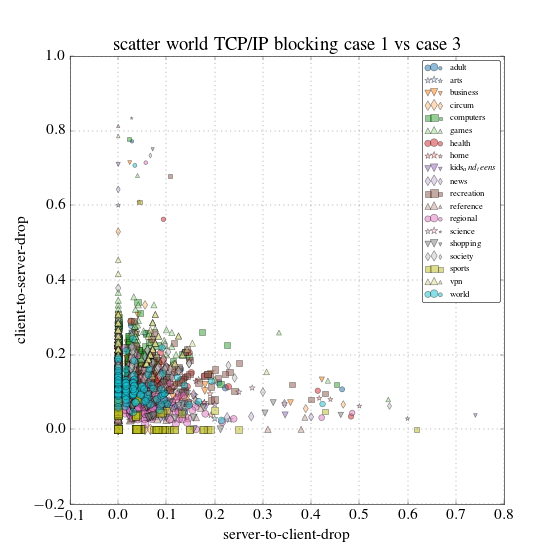

In [116]:
from itertools import cycle
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(7,7))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3', 'case2']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case1'], df4['case3'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat + ' TCP/IP blocking case 1 vs case 3')
ax2.set_xlabel('server-to-client-drop') #case1
ax2.set_ylabel('client-to-server-drop') #case3
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best')
fig2.savefig(RESULTS + model + '-global-density-by-subcat')

In [119]:
#df_filtered['case1/case13'] = df_filtered['case1']/(df_filtered['case3']+df_filtered['case1'])
df_filtered.head()

case     subcat country     case1     case2     case3    case13  case1/case13
0         adult      AE  0.100000  0.800000  0.100000  0.200000           0.5
1          arts      AE  0.075000  0.875000  0.050000  0.125000           0.6
2      business      AE  0.114286  0.714286  0.171429  0.285714           0.4
3        circum      AE  0.066667  0.866667  0.066667  0.133333           0.5
4     computers      AE  0.055556  0.722222  0.222222  0.277778           0.2

<IPython.core.display.Javascript object>


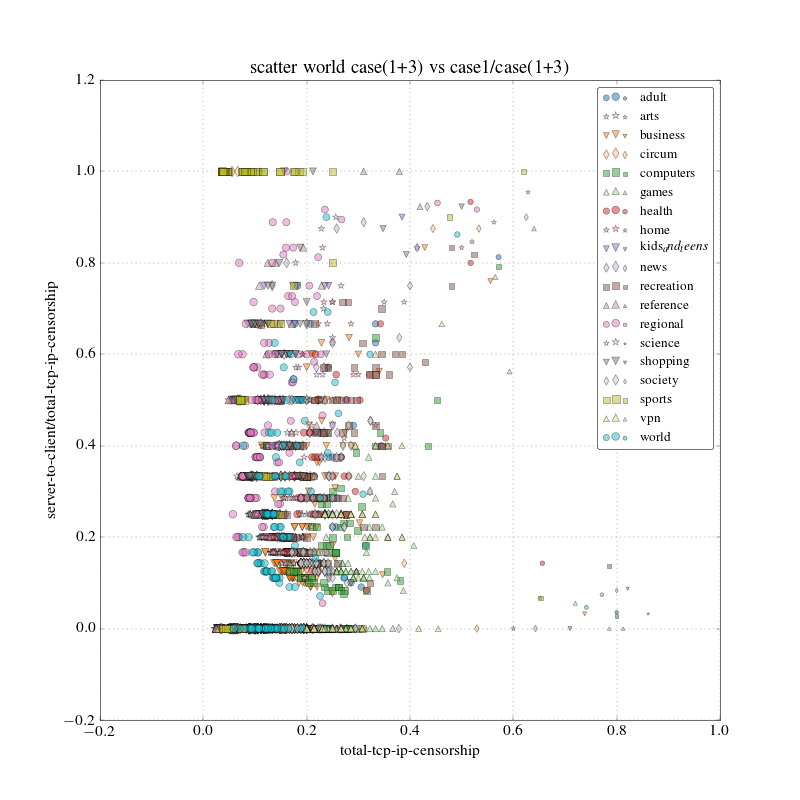

In [124]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(10,10))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case13','case2','case1/case13']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case13'], df4['case1/case13'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat )
ax2.set_ylabel('server-to-client/total-tcp-ip-censorship')+ ' case(1+3) vs case1/case(1+3)'
ax2.set_xlabel('total-tcp-ip-censorship')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best', prop={'size':12})
fig2.savefig(RESULTS + model + '-global-density-by-subcat-ratios')

<IPython.core.display.Javascript object>


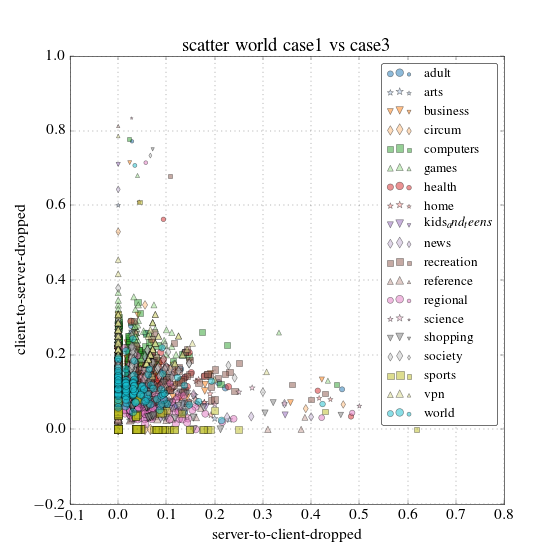

In [127]:
from itertools import cycle
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(7,7))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3', 'case2']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case1'], df4['case3'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat + ' case1 vs case3')

ax2.set_xlabel('server-to-client-dropped')
ax2.set_ylabel('client-to-server-dropped')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best', prop={'size':12})
fig2.savefig(RESULTS + model + '-global-density-by-subcat')

# COSINE SIMILARTY - TODO

In [131]:
from scipy.spatial.distance import cosine
df_censorship.head()
#df_multidim = df_filtered.pivot(index='case', columns='subcat')
#df_filtered.pivot()
#df_multidim.corr()

case country     subcat  1   2  3  total     case1     case2     case3  \
0         AE      adult  3  24  3     30  0.100000  0.800000  0.100000   
1         AE       arts  3  35  2     40  0.075000  0.875000  0.050000   
2         AE   business  4  25  6     35  0.114286  0.714286  0.171429   
3         AE     circum  1  13  1     15  0.066667  0.866667  0.066667   
4         AE  computers  2  26  8     36  0.055556  0.722222  0.222222   

case    case13  case1/case13  
0     0.200000           0.5  
1     0.125000           0.6  
2     0.285714           0.4  
3     0.133333           0.5  
4     0.277778           0.2